In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone: Predictive Validity of NBA Draft Combine Data


---

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, homogeneity_completeness_v_measure, v_measure_score,classification_report, plot_confusion_matrix, plot_roc_curve, confusion_matrix, plot_precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# 1. Background & Hypothesis

The National Basketball Assocation (NBA) has been holding a player draft every year since 1947. The draft is responsible for the influx of 60 players into the league each year. Teams and the media spend a lot of money and energy around this event as they try to get a strategic edge over their competitors and make the best predictions and select the best players available.

Every year, analysts and teams try to rank the available players based on various datasets and past performance. Major sports networks put a lot of effort into predicting the success of players and providing a great detail of in-depth analysis of each player for their customers to consume. One key aspect of this analyis centers around their biometric data. In order to collect this data, the NBA holds an annual NBA Combine where the players are put through a series of physical tests aimed to quantify their stature and athletic ability. This data is then made publicly available to teams and the media.

The aim of this project is to quantify the predictive validity of the publicly available biometric data, and discern if the intense focus given to this data is necessary and justifiable. My hypothesis is that, in isolation, it will not be a good prediction for succes. 

# 2. Data Gathering & Cleaning

In [4]:
nba_db = 'basketball.sqlite'

In [5]:
conn = sqlite3.connect(nba_db)
c = conn.cursor()
df_combine = pd.read_sql('select * from Draft_Combine', conn)
df_players = pd.read_sql('select * from Player_Attributes', conn)

### NBA Draft Combine Data

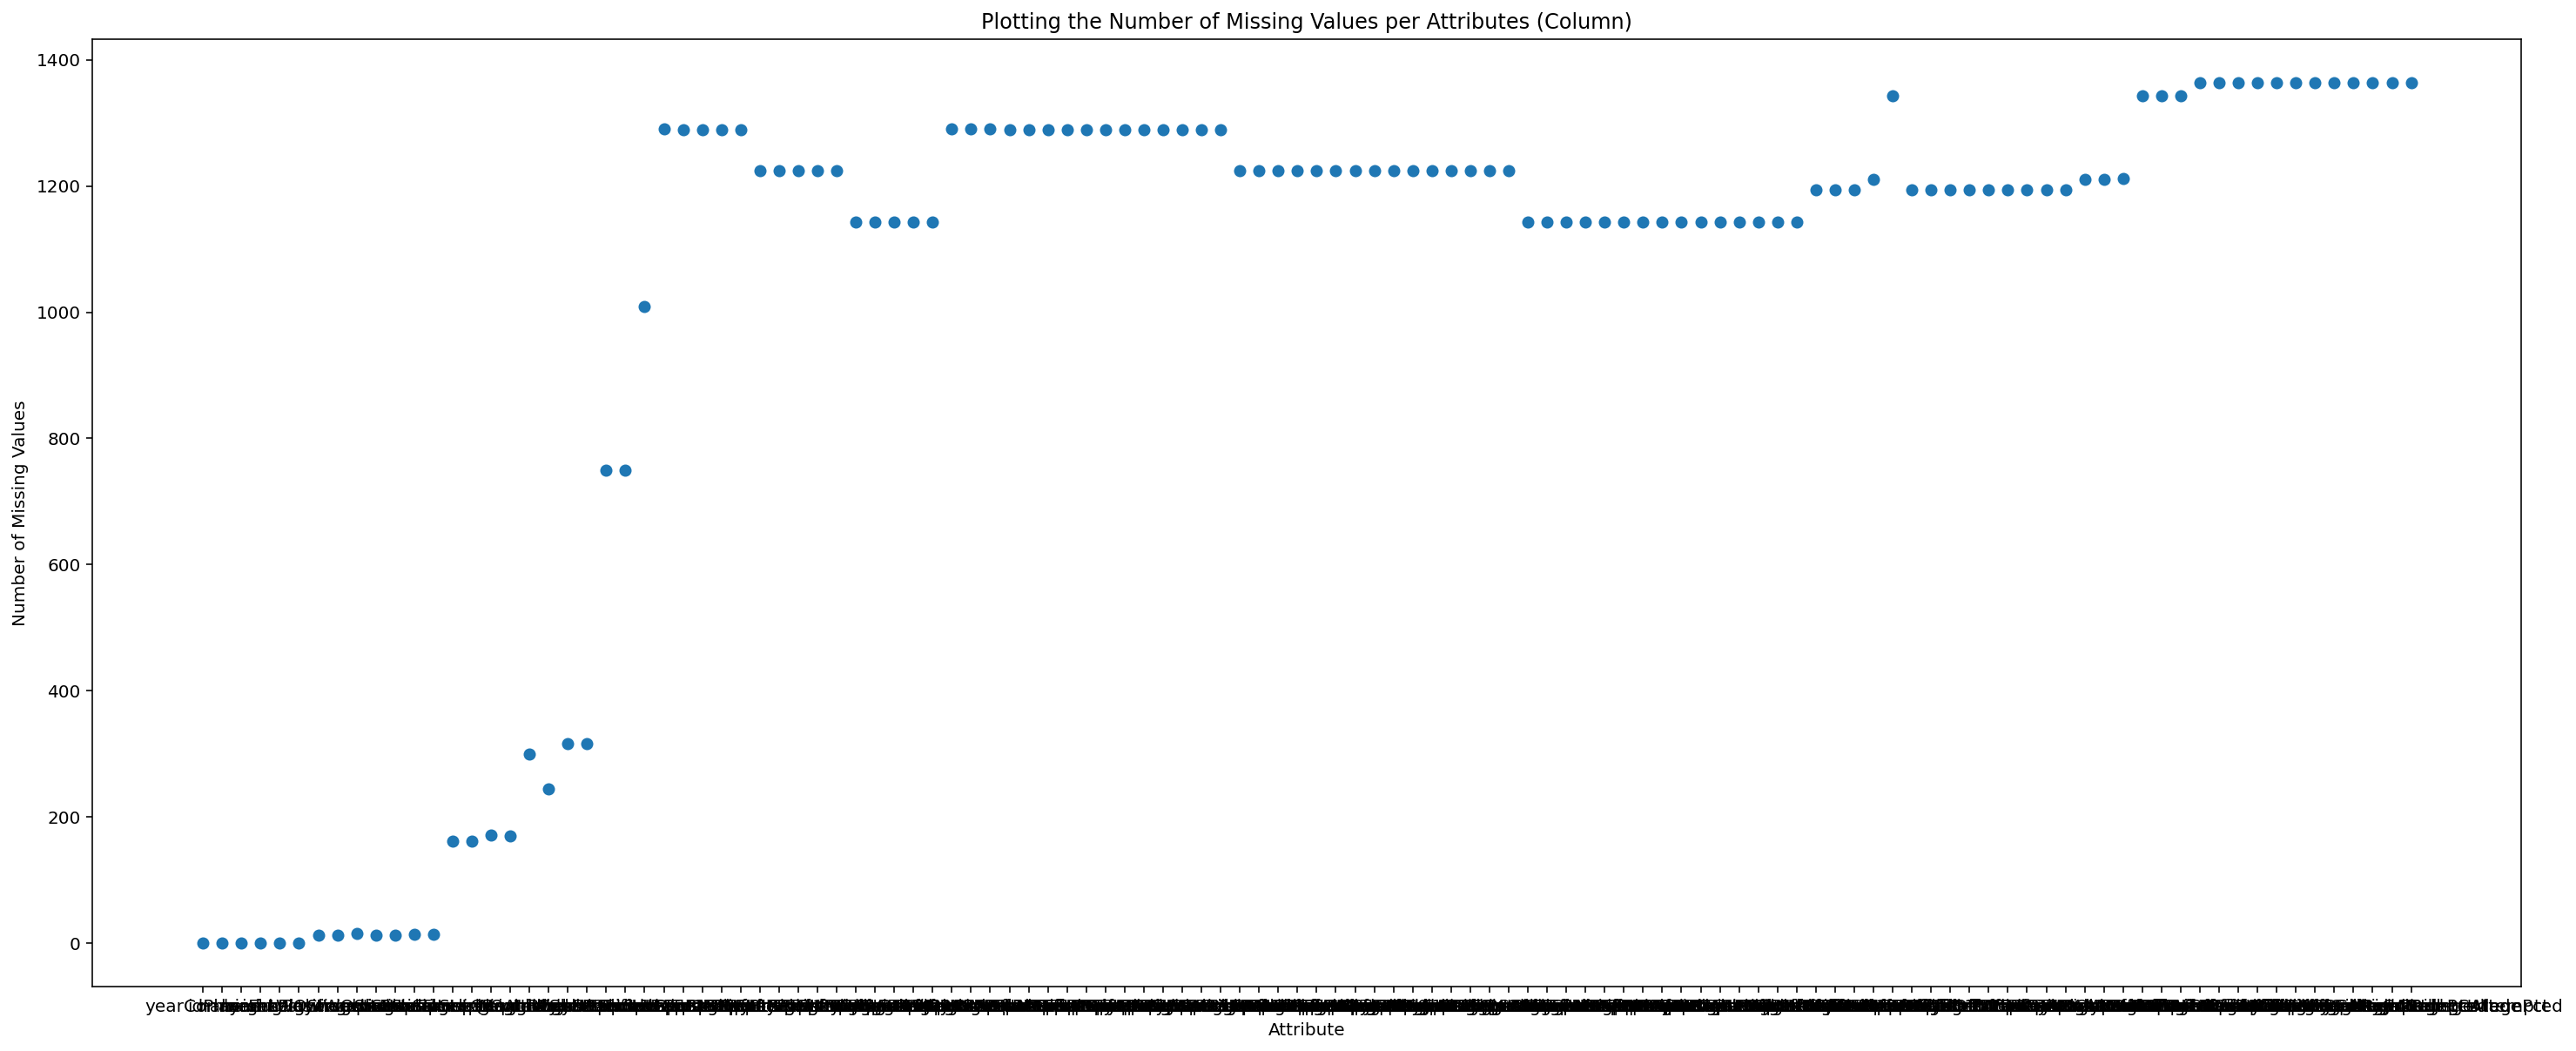

In [6]:
null_columns=[sum(df_combine[column].isnull()) for column in df_combine.columns]
plt.subplots(figsize=(25,10))
plt.scatter(x = df_combine.columns, y = null_columns)
plt.xlabel('Attribute')
plt.ylabel('Number of Missing Values')
plt.title('Plotting the Number of Missing Values per Attributes (Column)')
plt.show()

In [7]:
columns_to_keep = [column for column in df_combine.columns if (sum(df_combine[column].isnull()))<400]

In [8]:
columns_to_keep

['yearCombine',
 'idPlayer',
 'nameFirst',
 'nameLast',
 'namePlayer',
 'slugPosition',
 'heightWOShoesInches',
 'heightWOShoes',
 'weightLBS',
 'wingspanInches',
 'wingspan',
 'reachStandingInches',
 'reachStandingO',
 'verticalLeapStandingInches',
 'verticalLeapMaxInches',
 'timeLaneAgility',
 'timeThreeQuarterCourtSprint',
 'repsBenchPress135',
 'pctBodyFat',
 'heightWShoesInches',
 'heightWShoes']

In [9]:
# The last two columns made the cut but it doesn't seem necessary to keep as we already have height without shoes. Let's dropt these last two columns. 
columns_to_keep = columns_to_keep[:-2]

In [10]:
df_combine_new = df_combine[columns_to_keep]

In [11]:
df_combine_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   yearCombine                  1395 non-null   int64  
 1   idPlayer                     1395 non-null   float64
 2   nameFirst                    1395 non-null   object 
 3   nameLast                     1395 non-null   object 
 4   namePlayer                   1395 non-null   object 
 5   slugPosition                 1395 non-null   object 
 6   heightWOShoesInches          1382 non-null   float64
 7   heightWOShoes                1382 non-null   object 
 8   weightLBS                    1380 non-null   float64
 9   wingspanInches               1383 non-null   float64
 10  wingspan                     1383 non-null   object 
 11  reachStandingInches          1381 non-null   float64
 12  reachStandingO               1381 non-null   object 
 13  verticalLeapStandi

In [12]:
df_combine_new[df_combine_new.isnull().sum(axis=1)==0].shape

(845, 19)

In [13]:
# Only having 845 players does not seem like a sample size big enough. Let's see if there's anything we can do to bring that up. I am comfortable
# dropping the reachStandingO, wingspan and heightWOShoes variables as these are duplicates of other columns. 

In [14]:
df_combine_new = df_combine_new.drop(labels = ['reachStandingO','wingspan', 'heightWOShoes'], axis=1)

In [15]:
df_combine_new[df_combine_new.isnull().sum(axis=1)==0].shape

(845, 16)

In [16]:
# This did not improve our player count at all. Let's do some research into the percentage body fat and bench press as they seem to have a lot more null
# values that the other columns remaining. 

In [18]:
pd.DataFrame([df_combine.groupby(by='yearCombine')['pctBodyFat'].count(), df_combine.groupby(by='yearCombine')['repsBenchPress135'].count()])

yearCombine,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
pctBodyFat,0,76,0,77,80,0,76,76,76,46,...,54,61,63,56,58,55,61,69,69,45
repsBenchPress135,62,77,77,75,69,75,73,75,74,43,...,50,54,53,0,42,0,47,53,53,0


In [19]:
# from the above we can see that they didn't do any body percentage measurements in 2001 and 2003. Additionally, they didn't do any bench press
# measurements in 2015, 2017 and 2021. Because I do not want to lose all these years, I am okay dropping these columns. 

In [20]:
df_combine_new = df_combine_new.drop(labels = ['repsBenchPress135','pctBodyFat'], axis=1)

In [21]:
df_combine_new[df_combine_new.isnull().sum(axis=1)==0].shape

(1214, 14)

In [22]:
# now we can see that we have 1214 players of the possible 1395.

In [23]:
df_combine_clean = df_combine_new.dropna(how='any', axis=0)

In [24]:
# we can see that we have 1214 players as a result of my data cleaning. The columns that remain are the standard exercises that each participant
# goes through. They measure physical attributes such as height, wingspan, strength, speed and agility. 
df_combine_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 0 to 1394
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   yearCombine                  1214 non-null   int64  
 1   idPlayer                     1214 non-null   float64
 2   nameFirst                    1214 non-null   object 
 3   nameLast                     1214 non-null   object 
 4   namePlayer                   1214 non-null   object 
 5   slugPosition                 1214 non-null   object 
 6   heightWOShoesInches          1214 non-null   float64
 7   weightLBS                    1214 non-null   float64
 8   wingspanInches               1214 non-null   float64
 9   reachStandingInches          1214 non-null   float64
 10  verticalLeapStandingInches   1214 non-null   float64
 11  verticalLeapMaxInches        1214 non-null   float64
 12  timeLaneAgility              1214 non-null   float64
 13  timeThreeQuarterCo

In [25]:
df_combine_clean.describe()

,yearCombine,idPlayer,heightWOShoesInches,weightLBS,wingspanInches,reachStandingInches,verticalLeapStandingInches,verticalLeapMaxInches,timeLaneAgility,timeThreeQuarterCourtSprint
count,1214.000000,1.214000e+03,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000
mean,2010.070016,2.073273e+06,77.530643,215.886409,82.338221,103.311285,29.200371,34.389621,11.431244,3.285725
std,6.016126,5.632811e+07,3.421373,26.299180,4.048871,4.937455,3.120164,3.725008,0.607113,0.134765
min,2001.000000,-1.000000e+00,67.750000,149.200000,70.750000,88.500000,19.500000,21.000000,9.650000,2.910000
25%,2005.000000,1.213025e+04,75.062500,197.000000,79.750000,99.625000,27.000000,32.000000,11.000000,3.192500
50%,2009.000000,2.011980e+05,78.000000,214.000000,82.500000,103.500000,29.000000,34.500000,11.360000,3.270000
75%,2015.000000,2.039312e+05,80.250000,234.000000,85.250000,107.000000,31.500000,37.000000,11.777500,3.370000
max,2021.000000,1.962937e+09,89.250000,316.000000,98.250000,122.500000,39.500000,45.500000,14.450000,3.810000


In [26]:
# exporting our data frame to CSV as a back up. 
df_combine_clean.to_csv('nba_combine_dataframe.csv')

### Generating our success variable

Let us import a second data set that has the games played for players in their careers. We can join this with our current dataset to create a success variable

In [26]:
df_players_2 = pd.read_csv('all_seasons.csv')

In [27]:
df_players_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11145 entries, 0 to 11144
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         11145 non-null  int64  
 1   player_name        11145 non-null  object 
 2   team_abbreviation  11145 non-null  object 
 3   age                11145 non-null  float64
 4   player_height      11145 non-null  float64
 5   player_weight      11145 non-null  float64
 6   college            11145 non-null  object 
 7   country            11145 non-null  object 
 8   draft_year         11145 non-null  object 
 9   draft_round        11145 non-null  object 
 10  draft_number       11145 non-null  object 
 11  gp                 11145 non-null  int64  
 12  pts                11145 non-null  float64
 13  reb                11145 non-null  float64
 14  ast                11145 non-null  float64
 15  net_rating         11145 non-null  float64
 16  oreb_pct           111

In [28]:
df_games_played = df_players_2.groupby(by='player_name')['gp'].sum().reset_index()

In [29]:
np.min(df_games_played['gp'].unique())

1

Here we can see that the minimum number of games played for a player in the data set is 1. This indicates that it does not include players that did not play any games in the NBA. I predict this will leade to some NaN values when we merge our two datasets together. 

In [30]:
df_games_played['namePlayer'] = df_games_played['player_name']

In [31]:
df_full = pd.merge(df_combine_clean, df_games_played[['gp','namePlayer']], how='left', on='namePlayer')

In [32]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 0 to 1213
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   yearCombine                  1214 non-null   int64  
 1   idPlayer                     1214 non-null   float64
 2   nameFirst                    1214 non-null   object 
 3   nameLast                     1214 non-null   object 
 4   namePlayer                   1214 non-null   object 
 5   slugPosition                 1214 non-null   object 
 6   heightWOShoesInches          1214 non-null   float64
 7   weightLBS                    1214 non-null   float64
 8   wingspanInches               1214 non-null   float64
 9   reachStandingInches          1214 non-null   float64
 10  verticalLeapStandingInches   1214 non-null   float64
 11  verticalLeapMaxInches        1214 non-null   float64
 12  timeLaneAgility              1214 non-null   float64
 13  timeThreeQuarterCo

In [33]:
df_full[(df_full['gp'].isnull()) & (df_full['yearCombine'] == 2020)]

,yearCombine,idPlayer,nameFirst,nameLast,namePlayer,slugPosition,heightWOShoesInches,weightLBS,wingspanInches,reachStandingInches,verticalLeapStandingInches,verticalLeapMaxInches,timeLaneAgility,timeThreeQuarterCourtSprint,gp
1120,2020,1629646.0,Charles,Bassey,Charles Bassey,C,80.75,239.0,87.50,109.5,29.0,33.0,12.65,3.53,NaN
1126,2020,1629052.0,O'Shae,Brissett,O'Shae Brissett,SF-PF,79.00,203.2,84.00,104.0,34.0,37.5,11.30,3.48,NaN
1133,2020,1629653.0,Devon,Dotson,Devon Dotson,PG,72.00,178.6,75.25,95.5,30.0,38.5,10.63,3.04,NaN
1138,2020,1629656.0,Quentin,Grimes,Quentin Grimes,SG,76.00,209.6,79.75,100.5,27.5,36.0,10.83,3.20,NaN
1140,2020,1628986.0,Jaylen,Hands,Jaylen Hands,PG,73.50,180.4,77.50,97.0,33.0,41.5,10.73,3.12,NaN
1144,2020,1629658.0,Jalen,Hoard,Jalen Hoard,PF,79.25,212.6,84.75,105.5,27.5,35.5,11.44,3.34,NaN
1150,2020,1629664.0,Dedric,Lawson,Dedric Lawson,PF,79.00,233.0,86.25,107.5,23.5,26.0,11.80,3.60,NaN
1155,2020,1629666.0,Charles,Matthews,Charles Matthews,SG,77.00,194.8,81.50,103.0,29.5,37.5,11.26,3.38,NaN
1162,2020,1629617.0,Reggie,Perry,Reggie Perry,SF-PF,80.00,250.8,84.50,106.0,28.5,31.5,12.46,3.30,NaN
1166,2020,1629674.0,Neemias,Queta,Neemias Queta,C,82.75,225.8,88.25,111.5,24.0,32.5,12.04,3.73,NaN


From the analysis above, it seems that the games played data set doesn't contain the player if they've played zero gomes. This makes me think that all the missing values are b/c the player never played a game in the NBA. This is highly possibly as only 60 players get selected each year and only a subset of them every see the NBA floor. In order to confirm my suspicion, I googled a large portion of the names and my suspcisions were confirmed. To further confirm them, let us merge again and pull in the draft year. 

In [34]:
df_players = df_players.rename(columns={'ID':'idPlayer'})

In [35]:
df_players['idPlayer'] = df_players.idPlayer.map(lambda x: float(x))

In [36]:
pd.merge(df_full, df_players[['idPlayer','DRAFT_YEAR']], how='left', on='idPlayer')[['gp','DRAFT_YEAR']].iloc[0:50,:]

,gp,DRAFT_YEAR
0,478.0,Undrafted
1,NaN,NaN
2,NaN,NaN
3,342.0,2000
4,334.0,2000
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,50.0,2000


From the analysis above, we see that the players that have NaNs as GP also have NaNs as the DRAFT_YEAR. This means that they did not enter the draft
and never played a game in the NBA. As such, I am comfortable setting this to 0 and moving forward with making my success variable. 

In [37]:
df_full['gp'].fillna(0, inplace=True)

Now we have to determine the binary success target based on the games played. In order to take into account length of their careers I am going to measure success as the mean number of games players played in their draft year. 

In [38]:
success_benchmark = df_full.groupby(by='yearCombine')['gp'].mean()
success_benchmark.index.name=None
success_benchmark.head()

2001     90.561404
2002    215.092105
2003    188.416667
2004    236.800000
2005    238.211268
Name: gp, dtype: float64

In [39]:
i = 0
success = []
for year in success_benchmark.index:
    success.extend(list(df_full[df_full['yearCombine'] == year]['gp'] > success_benchmark.iloc[i]))
    i += 1

In [40]:
df_full['Success'] = np.array(success).astype(int)

In [41]:
df_full['Success'].value_counts(normalize=True)

0    0.656507
1    0.343493
Name: Success, dtype: float64

In [42]:
# Manually correcting some null values. 
df_full['nameLast'][133] = 'Nene'
df_full['slugPosition'][372] = 'SG'

<ipython-input-42-1858613a1094>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['nameLast'][133] = 'Nene'
<ipython-input-42-1858613a1094>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['slugPosition'][372] = 'SG'


In [43]:
# This is a reasonable success rate given the likelihood of making the NBA and then playing above the mean number of games for your draft year. 
# This implies that of the 60 players drafted each year, only around 19 play above the mean number of games for the year. 

df_combine_final = df_full

In [44]:
df_combine_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 0 to 1213
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   yearCombine                  1214 non-null   int64  
 1   idPlayer                     1214 non-null   float64
 2   nameFirst                    1214 non-null   object 
 3   nameLast                     1214 non-null   object 
 4   namePlayer                   1214 non-null   object 
 5   slugPosition                 1214 non-null   object 
 6   heightWOShoesInches          1214 non-null   float64
 7   weightLBS                    1214 non-null   float64
 8   wingspanInches               1214 non-null   float64
 9   reachStandingInches          1214 non-null   float64
 10  verticalLeapStandingInches   1214 non-null   float64
 11  verticalLeapMaxInches        1214 non-null   float64
 12  timeLaneAgility              1214 non-null   float64
 13  timeThreeQuarterCo

In [45]:
df_combine_final.to_csv('combine_data_final.csv')


| _Attribute_ | _Description_ |
|---|---|
| **yearCombine** | The year the player participated in the NBA Draft Combine|
| **idPLayer** | The unique ID of the player. This was given by the creator of the NBA SQLite Database|
| **nameFirst** | The first name of the NBA player|
| **nameLast** | The last name of the NBA player|
| **namePlayer** | The full name of the NBA player|
| **slugPosition** | The position of the NBA player|
| **heightWOShoesInches** | The official height of the NBA player without shoes on, in inches|
| **weightLBS** | The official weight of the NBA player in pounds|
| **wingspanInches** | The official wingspan of the NBA player in inches|
| **reachStandingInches** | The official standing reach of the NBA player in inches|
| **verticalLeapStandingInches** | The official standing vertical leap of the NBA player in inches|
| **verticalLeapMaxInches** | The official maximum vertical leap of the NBA player in inches. In this scenario they are permitted to take a run-up|
| **timeLaneAgility** | The official time it took them to complete the lane agility test, in seconds|
| **timeThreeQuarterCourtSprint** | The official time it the NBA player to sprint three quarters of the court, in seconds|
| **gp** | The total games played of the NBA player during their career|
| **Success** | Binary variable indicating the player was a success or not|


# 3. Exploratory Data Analysis 

In [47]:
df = df_combine_final[df_combine_final.yearCombine != 2021]
df = df.drop(['gp'], axis=1)

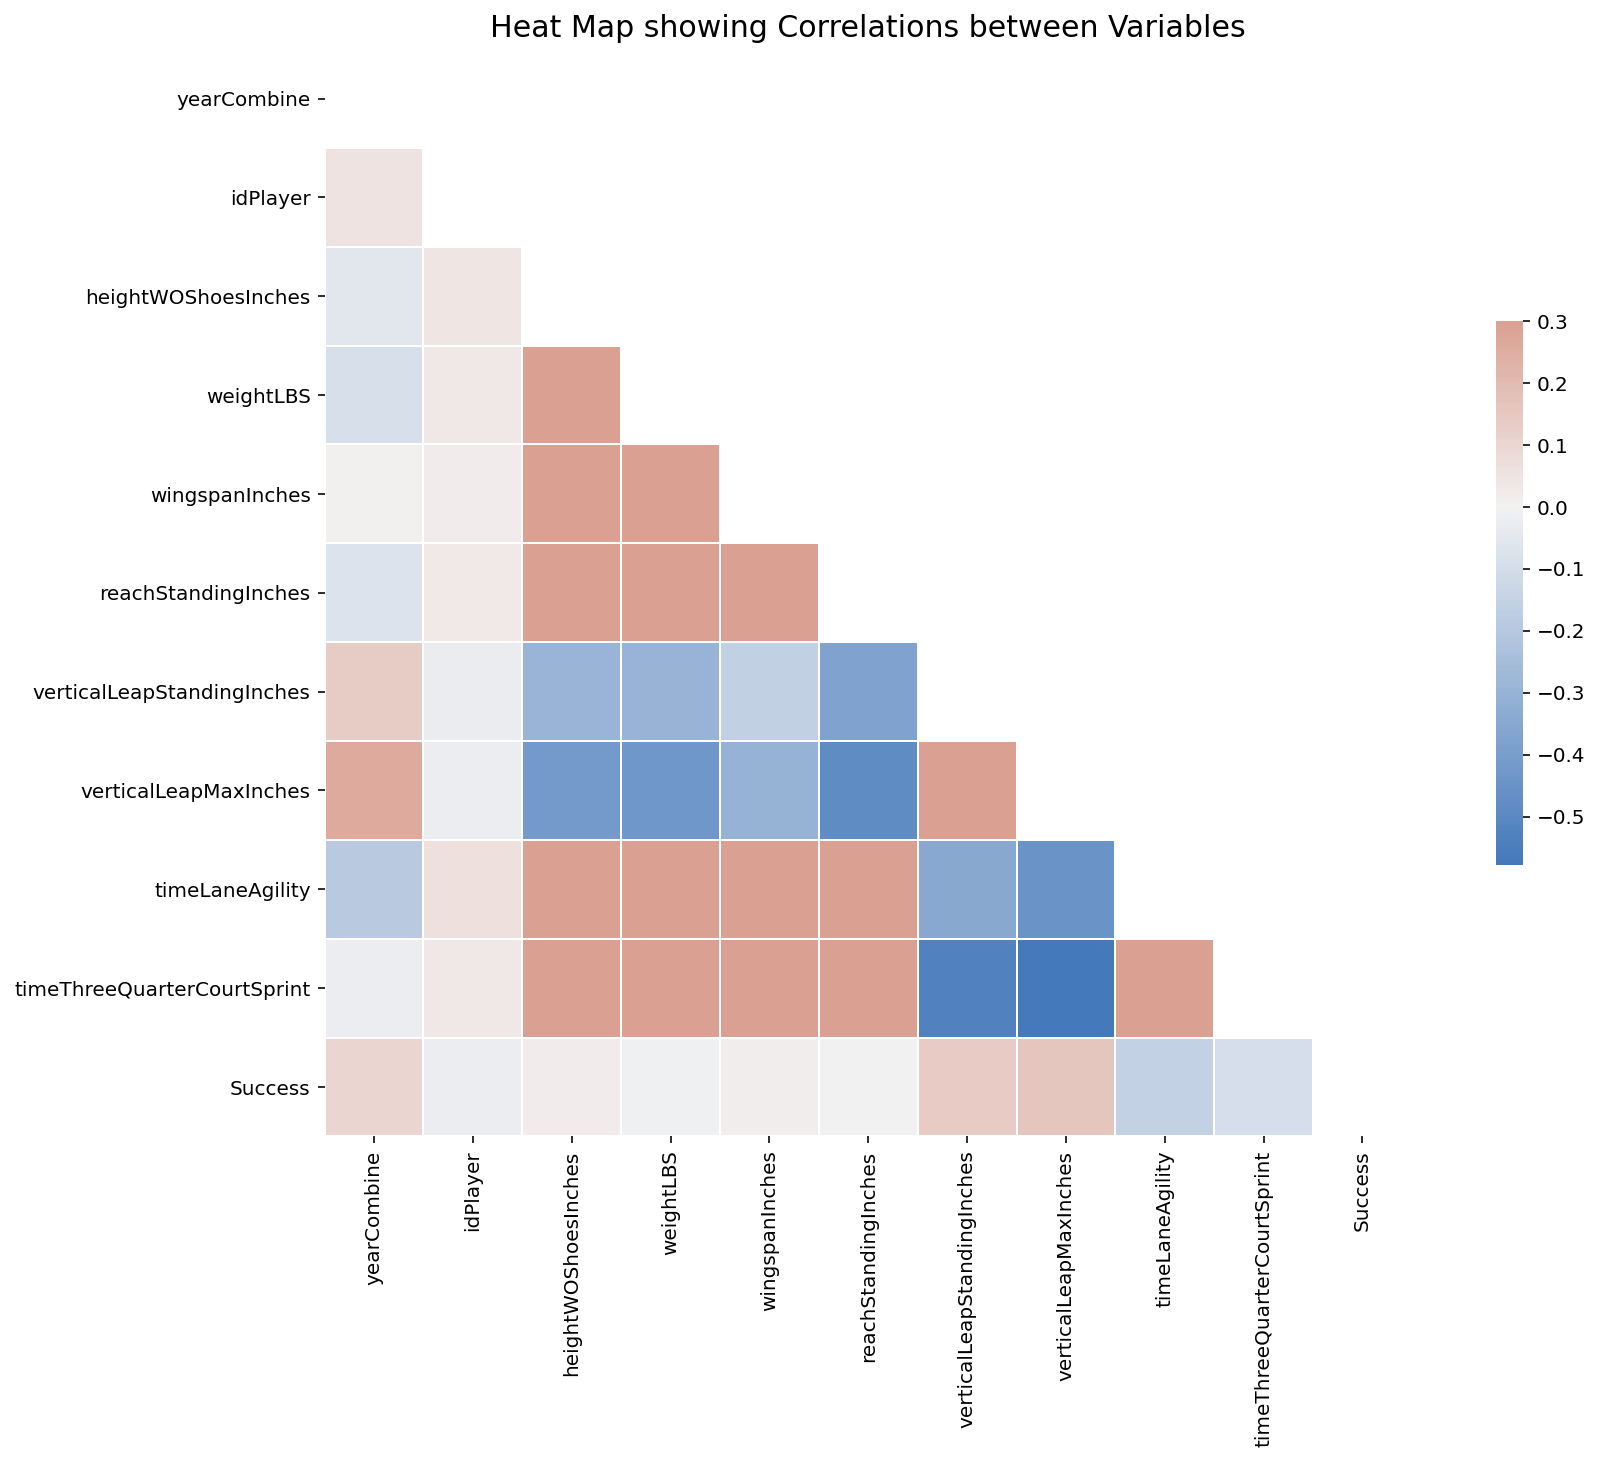

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(250, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heat Map showing Correlations between Variables', fontsize = 15)
plt.show()

From the initial correlation heatmap, it does not seem that many of the predictor variables have a strong relationship with my measure for success. In general, the direction of the correlation is what we'd expect. The more athletic you are, the more likely you are to be successful in the NBA (per my definition of success).

In [49]:
median_tla = [df[df.yearCombine==i]['timeLaneAgility'].median() for i in df.yearCombine.unique()]
median_vleap = [df[df.yearCombine==i]['verticalLeapMaxInches'].median() for i in df.yearCombine.unique()]
median_sprint = [df[df.yearCombine==i]['timeThreeQuarterCourtSprint'].median() for i in df.yearCombine.unique()]

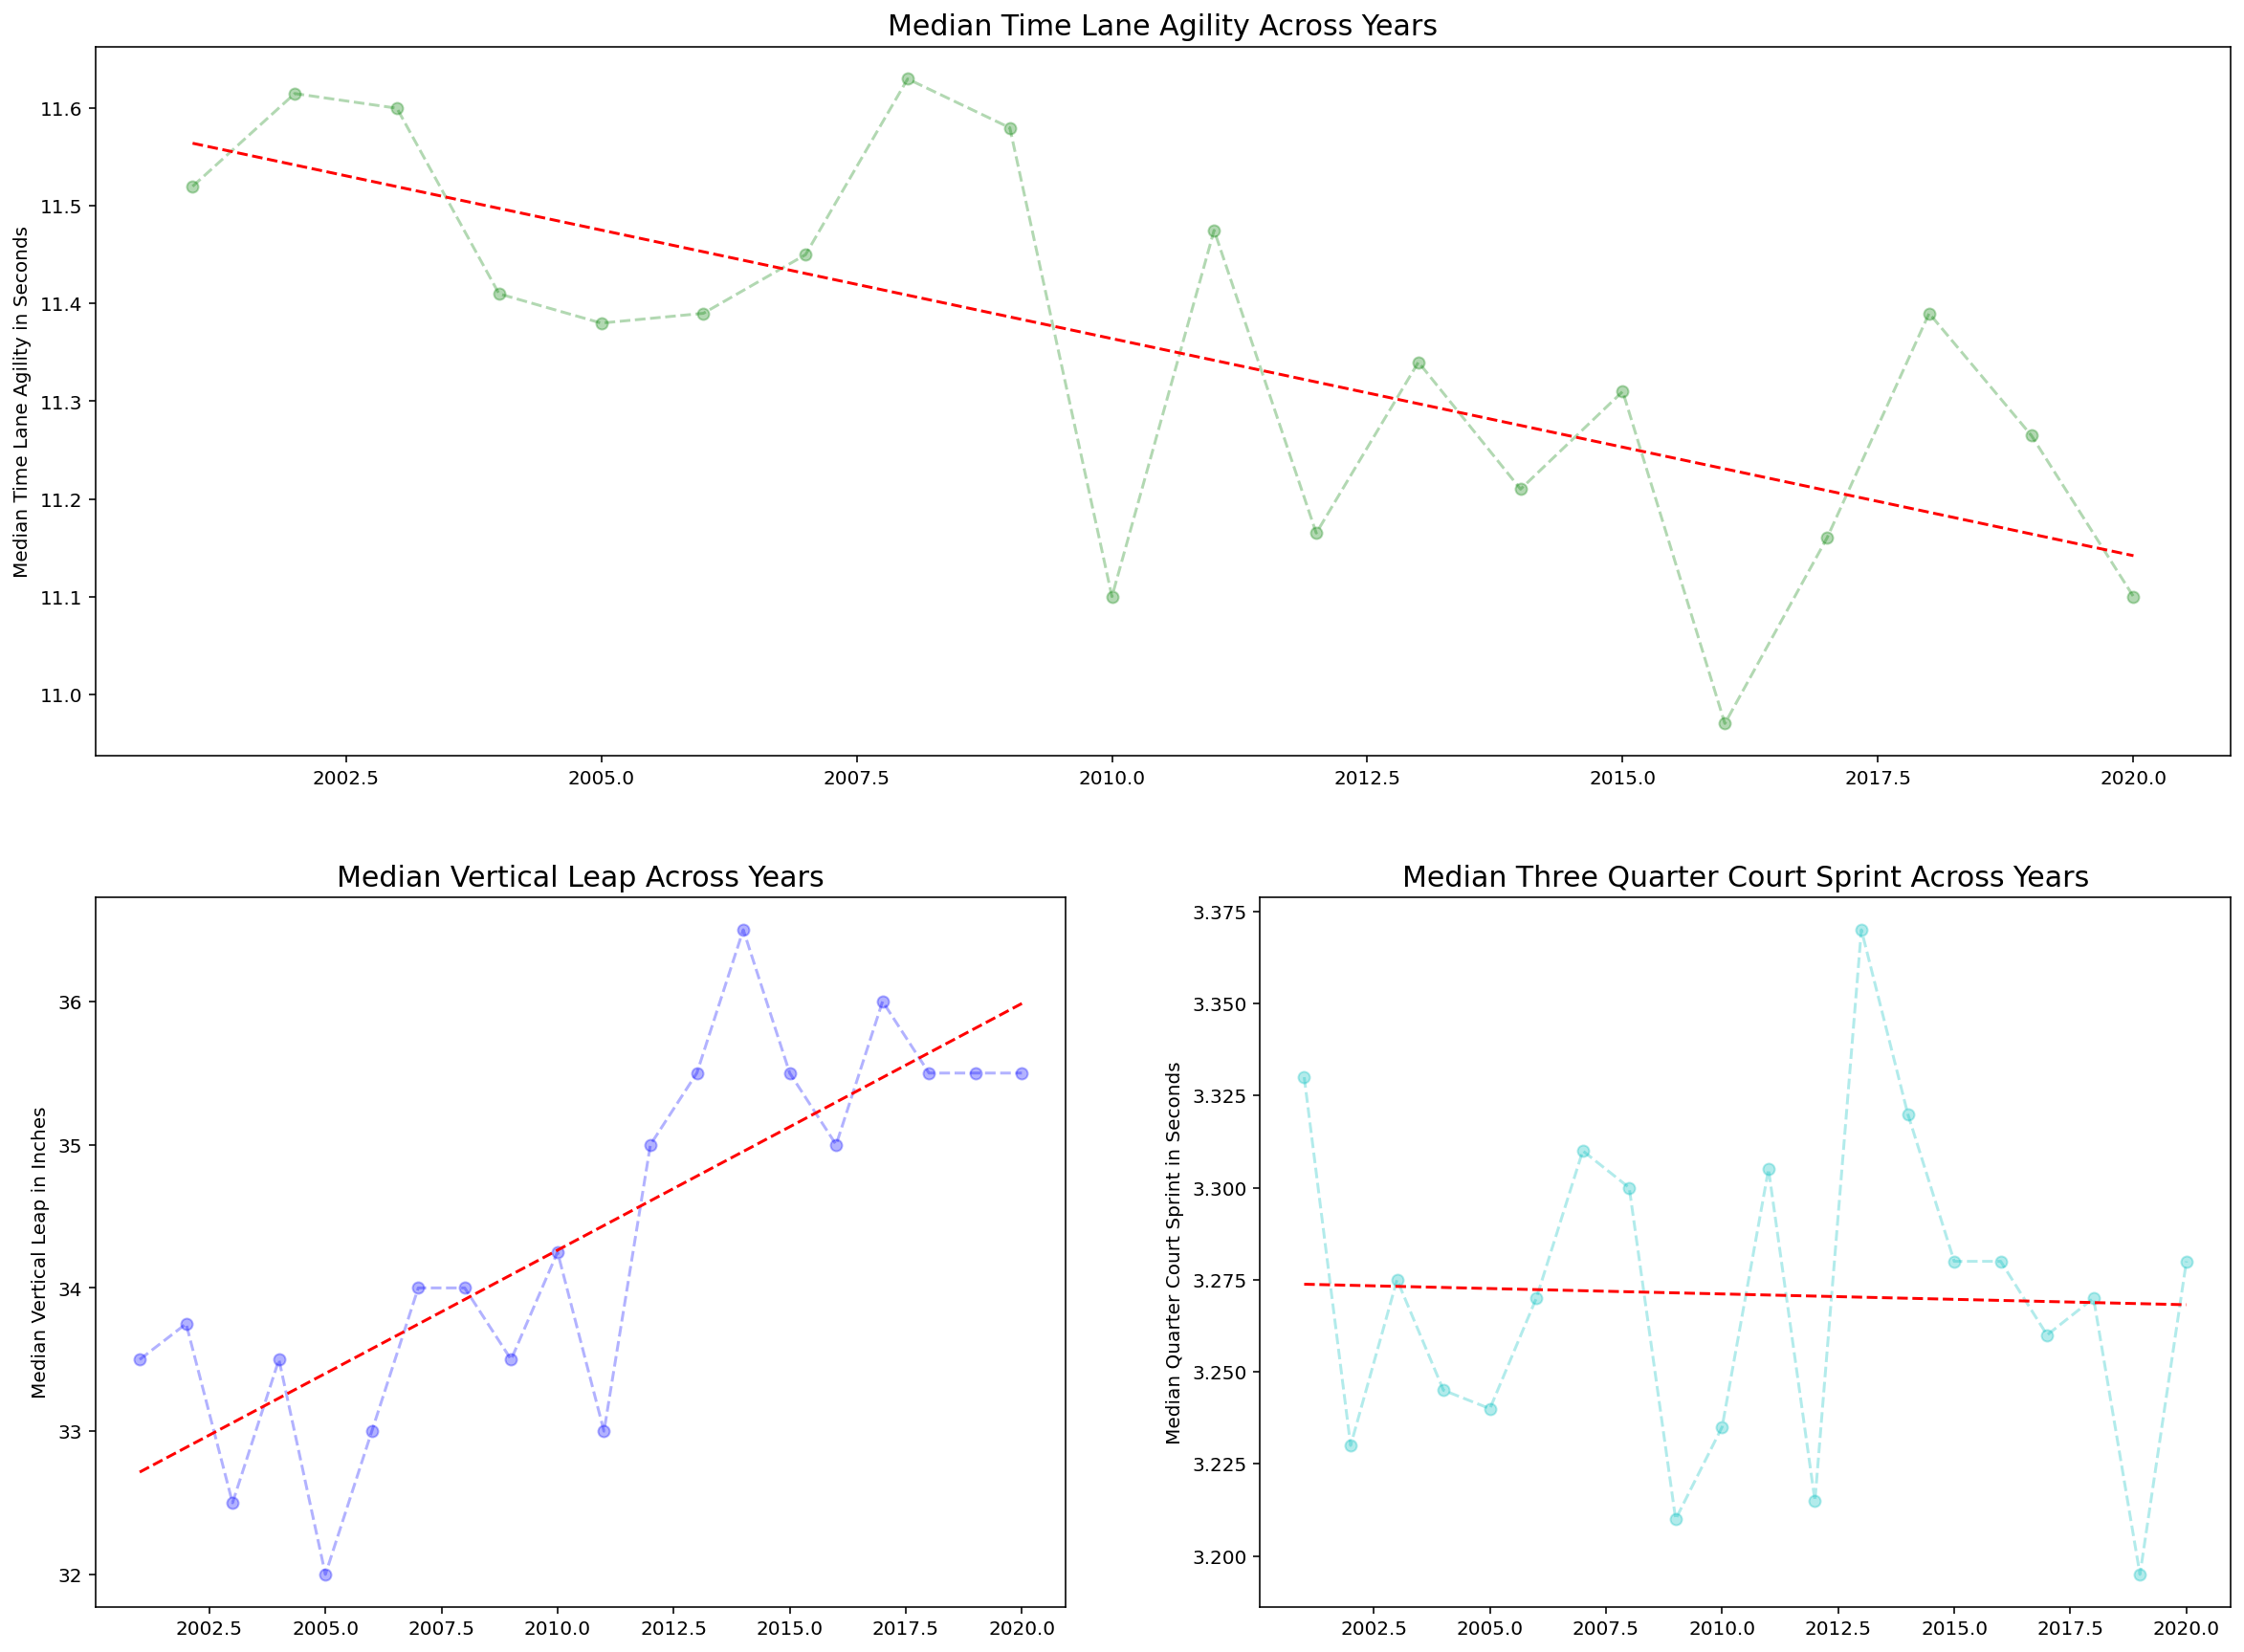

In [50]:
fig = plt.subplots(figsize = (20,15))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.plot(df.yearCombine.unique(), median_tla, 'go--', alpha=0.3)
z = np.polyfit(df.yearCombine.unique(), median_tla, 1)
p = np.poly1d(z)
ax1.plot(df.yearCombine.unique(),p(df.yearCombine.unique()),"r--")
plt.title('Median Time Lane Agility Across Years', fontsize = 15)
plt.ylabel('Median Time Lane Agility in Seconds')

ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax2.plot(df.yearCombine.unique(), median_vleap, 'bo--', alpha = 0.3)
z = np.polyfit(df.yearCombine.unique(), median_vleap, 1)
p = np.poly1d(z)
ax2.plot(df.yearCombine.unique(),p(df.yearCombine.unique()),"r--")
plt.title('Median Vertical Leap Across Years', fontsize = 15)
plt.ylabel('Median Vertical Leap in Inches')

ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
ax3.plot(df.yearCombine.unique(), median_sprint, 'co--', alpha=0.3)
z = np.polyfit(df.yearCombine.unique(), median_sprint, 1)
p = np.poly1d(z)
ax3.plot(df.yearCombine.unique(),p(df.yearCombine.unique()),"r--")
plt.title('Median Three Quarter Court Sprint Across Years', fontsize = 15)
plt.ylabel('Median Quarter Court Sprint in Seconds')
plt.show()

From the graphs above, we see that there seems to be a general downward trend for the time lane agility, and a general upward trend for the maximum vertical leap. Both these indicate that over the years, partcipants of the draft combine have become more athletic. However, that can not be conclusively determined from the data. 

In [51]:
# Now let's do the same for physical attributes, not athletic ability. 
median_height = [df[df.yearCombine==i]['heightWOShoesInches'].median() for i in df.yearCombine.unique()]
median_wingspan = [df[df.yearCombine==i]['wingspanInches'].median() for i in df.yearCombine.unique()]
median_lbs = [df[df.yearCombine==i]['weightLBS'].median() for i in df.yearCombine.unique()]

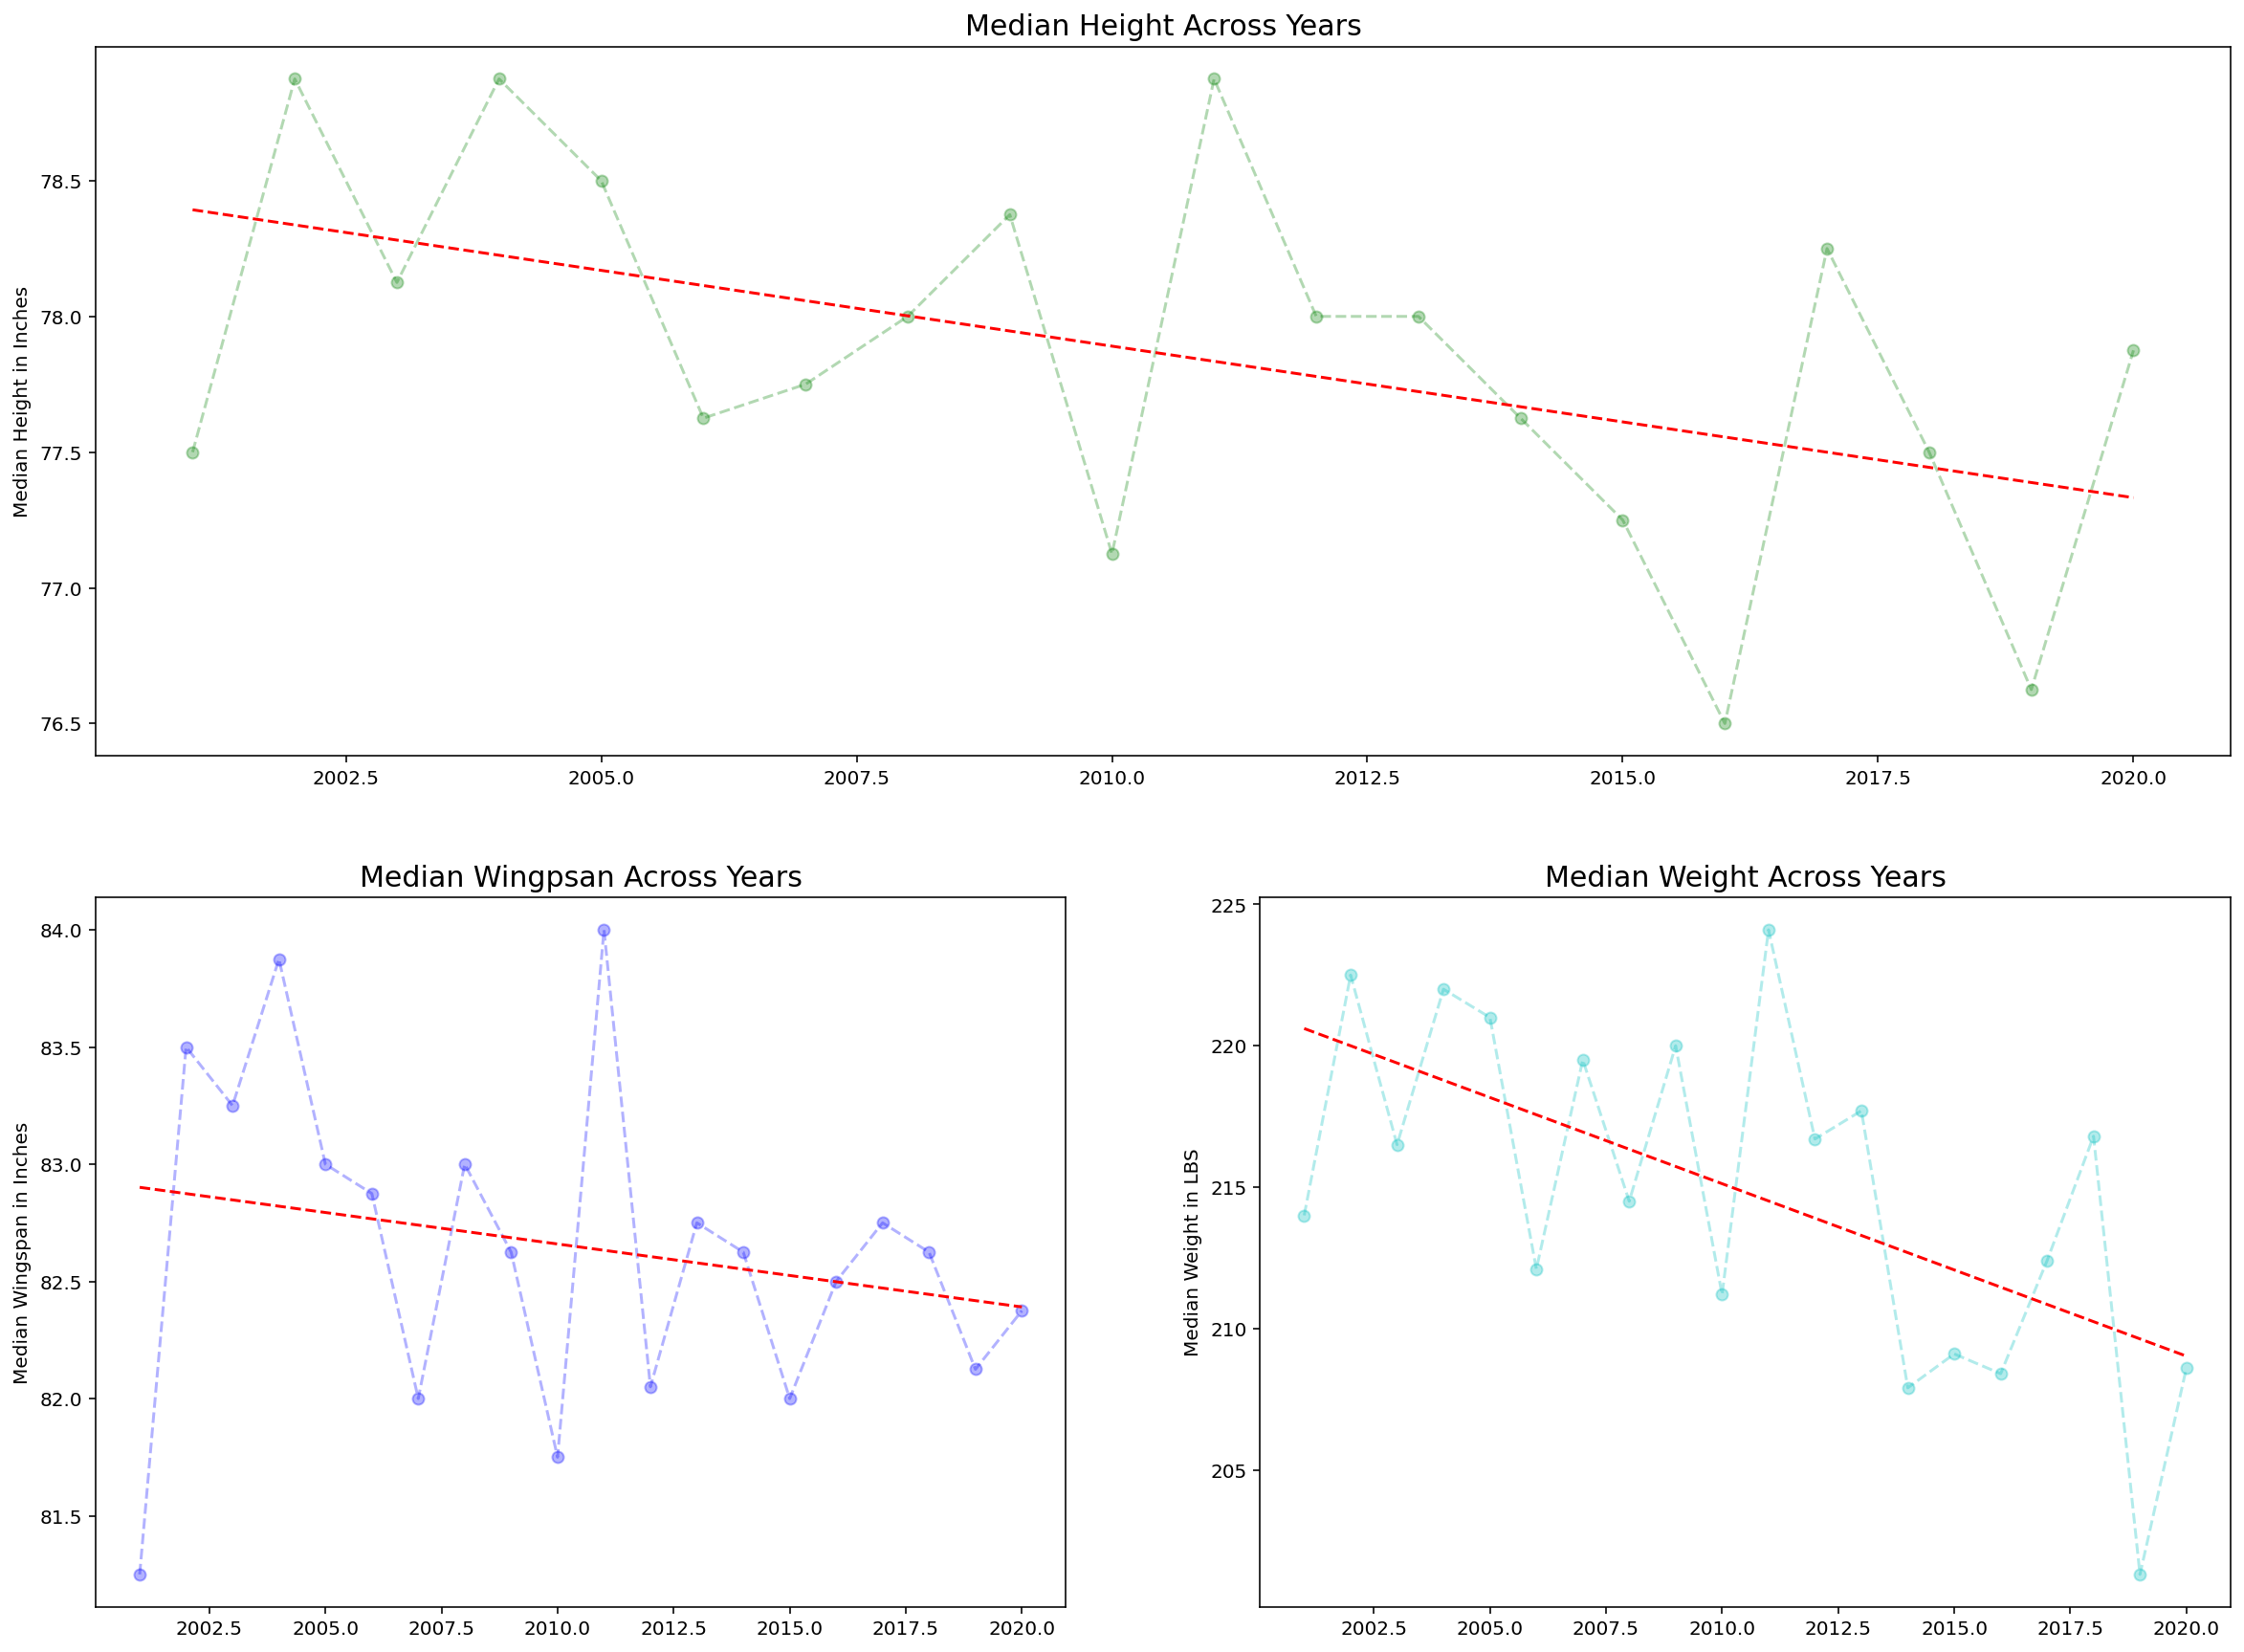

In [52]:
fig = plt.subplots(figsize = (20,15))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1.plot(df.yearCombine.unique(), median_height,'go--', alpha=0.3)
z = np.polyfit(df.yearCombine.unique(), median_height, 1)
p = np.poly1d(z)
ax1.plot(df.yearCombine.unique(),p(df.yearCombine.unique()),"r--")
plt.title('Median Height Across Years', fontsize = 15)
plt.ylabel('Median Height in Inches')


ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax2.plot(df.yearCombine.unique(), median_wingspan, 'bo--', alpha = 0.3)
z = np.polyfit(df.yearCombine.unique(), median_wingspan, 1)
p = np.poly1d(z)
ax2.plot(df.yearCombine.unique(),p(df.yearCombine.unique()),"r--")
plt.title('Median Wingpsan Across Years', fontsize = 15)
plt.ylabel('Median Wingspan in Inches')


ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
ax3.plot(df.yearCombine.unique(), median_lbs, 'co--', alpha=0.3)
z = np.polyfit(df.yearCombine.unique(), median_lbs, 1)
p = np.poly1d(z)
ax3.plot(df.yearCombine.unique(),p(df.yearCombine.unique()),"r--")
plt.title('Median Weight Across Years', fontsize = 15)
plt.ylabel('Median Weight in LBS')
plt.show()

From the above graphs, we see that there is a consitent downtrend in the median weight of the players, and a small downtrend in the median height of the players. Note, these trends are not conclusive but do give some insight into the general direction of the biometric information of NBA prospects that participate in the draft. 

Now, let us examine if there are any outliers in the biometric data of the players. In order to visually represent them all on the same graph, we need to first standardize the data. 

In [53]:
scaler = StandardScaler()
df_bio_std = pd.DataFrame(scaler.fit_transform(df.iloc[:,6:14]), columns=df.iloc[:,6:14].columns)

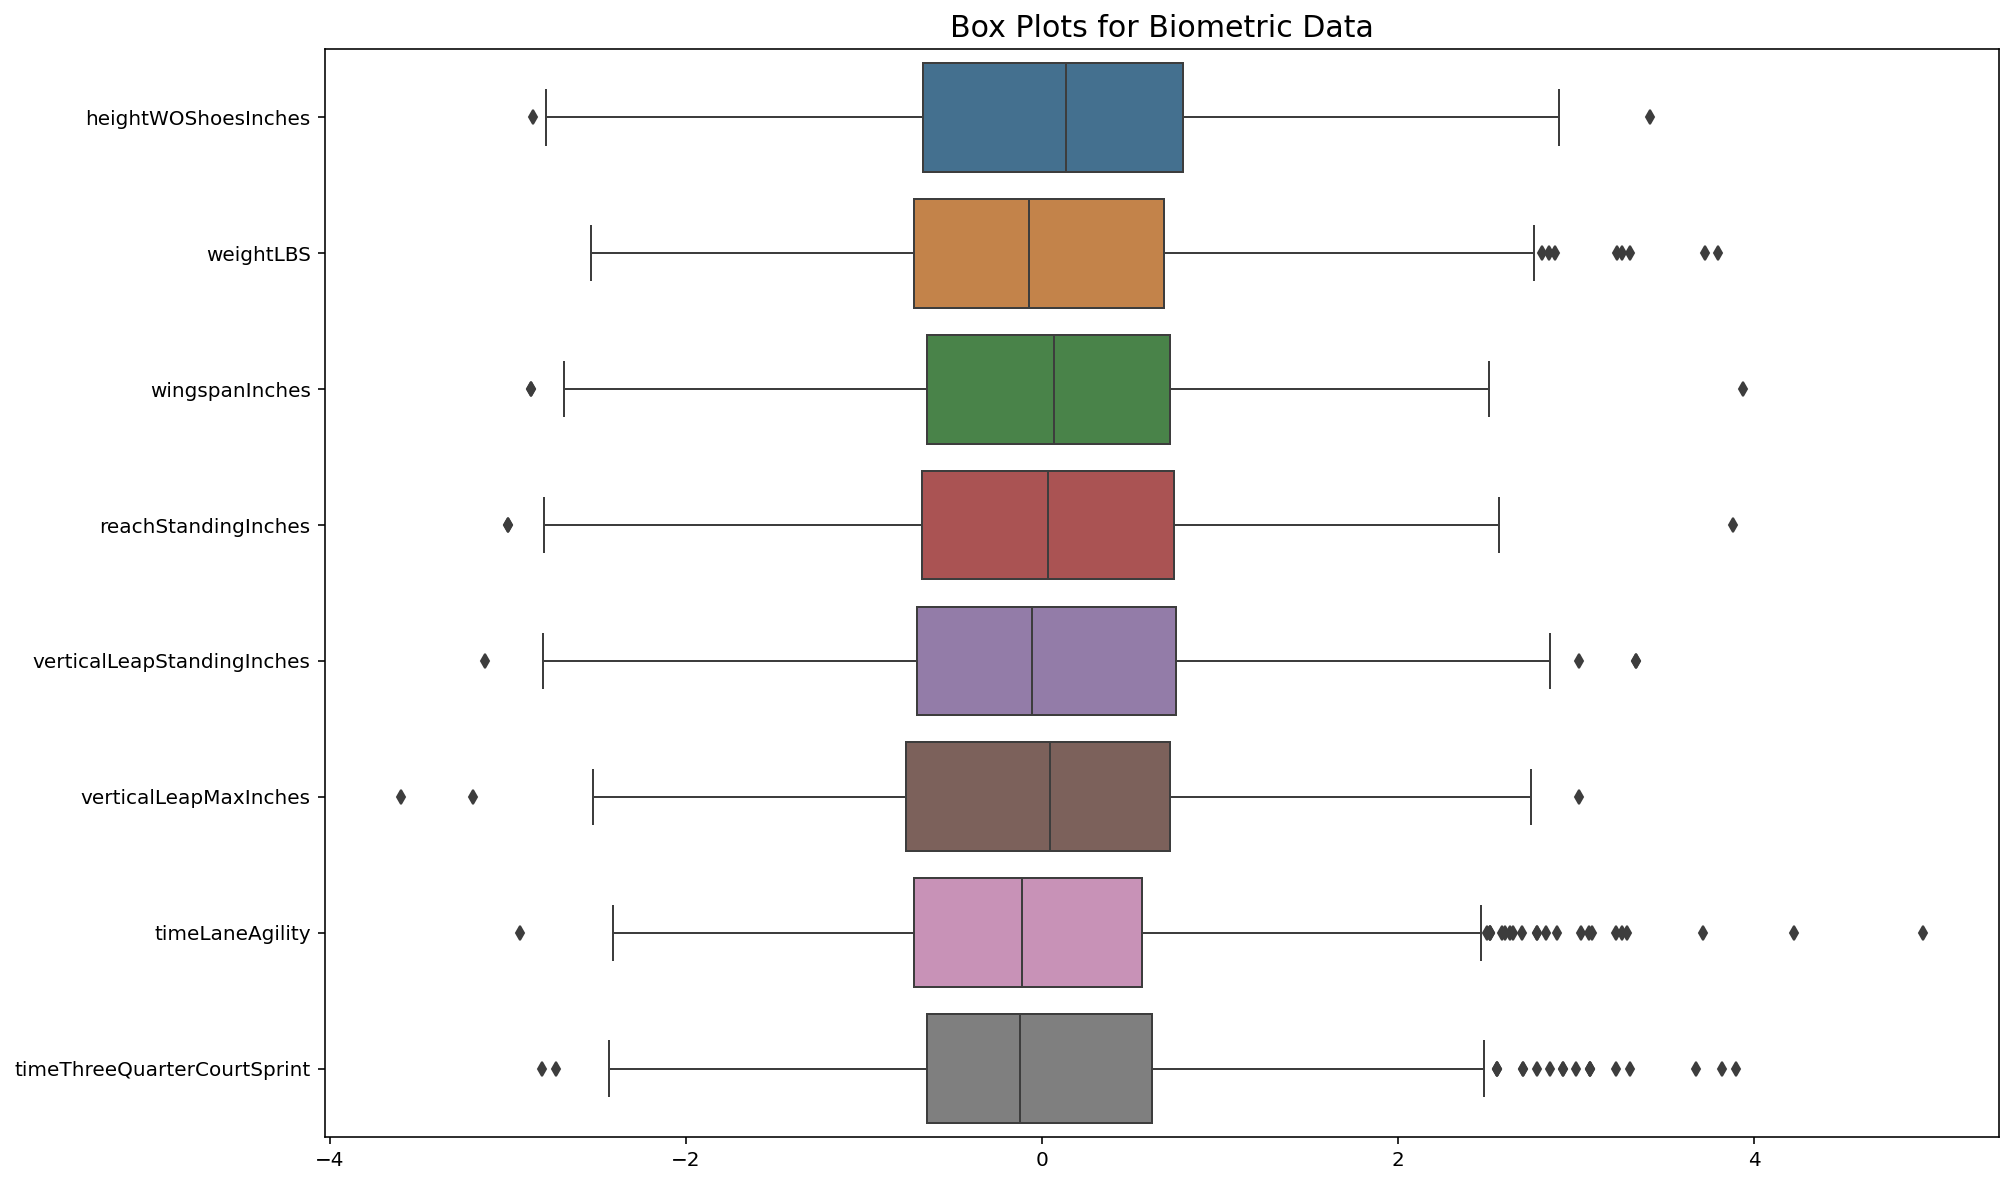

In [54]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df_bio_std, orient='h', fliersize=5, linewidth=1, notch=False, saturation=0.5, ax=ax)
plt.title('Box Plots for Biometric Data', fontsize = 15)
plt.show()

From the boxplots for biometric data, we do not see that many outliers. Remeber, an outlier can be defined as anything outside the IQRs. In this case, most outliers exist in the athletic ability rather than the physical attributes of the players. However, due to the size of the data set and the number of outliers, I do not think these will dramatically impact the overall results. 

Another interesting thing to explore is the count of players at each position over the years. The NBA has shifted towards 'small-ball' and away from the more traditional tall players. Our slug position feature has 13 different options so let's see if we can cluster the biometric data and produce some insights that would allow us to shrink this number to a more manageable amount. 

In [55]:
df['slugPosition'].unique()

array(['PF-C', 'PF', 'C', 'PG', 'SG-SF', 'SF', 'SF-PF', 'PG-SG', 'SG-PG',
       'SG', 'C-PF', 'PF-SF', 'SF-SG'], dtype=object)

### Clustering Exercise

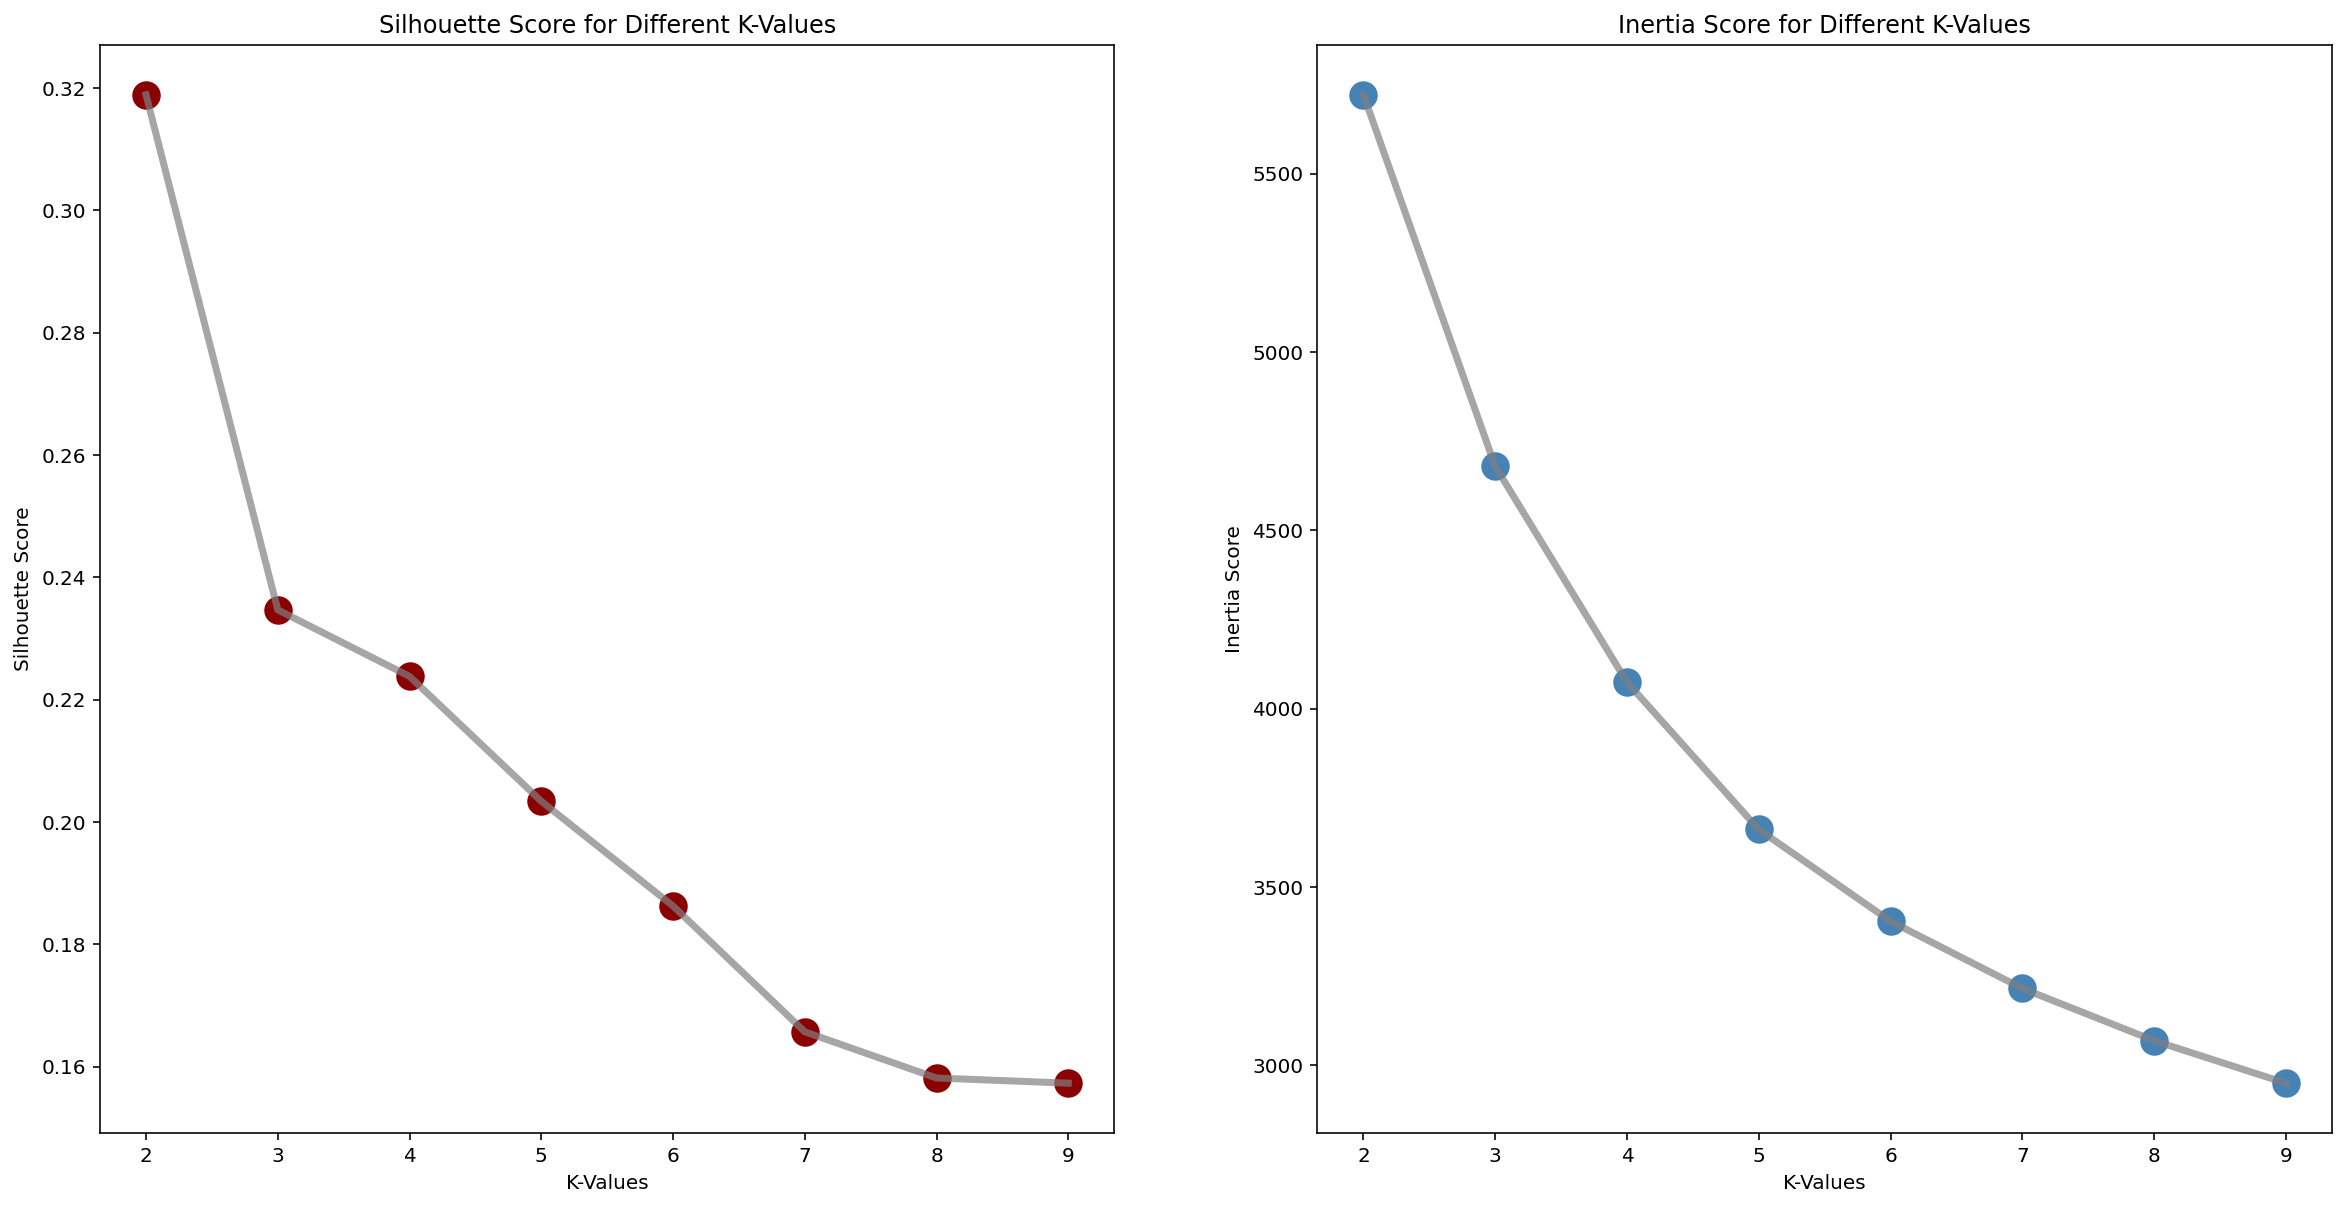

In [56]:
sils = []
inertia = []
k_values = range(2, 10)
for k in k_values:
    km = KMeans(n_clusters=k)
    km.fit(df_bio_std)
    sils.append(silhouette_score(df_bio_std, km.labels_, metric='euclidean'))
    inertia.append(km.inertia_)

fig, ax = plt.subplots(ncols = 2, figsize=(20, 10))
ax[0].plot(k_values, sils, c='grey', lw=3.5, alpha=0.7)
ax[0].scatter(k_values, sils, c='darkred', s=175)
ax[0].set_title('Silhouette Score for Different K-Values'), ax[0].set_xlabel('K-Values'), ax[0].set_ylabel('Silhouette Score')
ax[1].plot(k_values, inertia, c='grey', lw=3.5, alpha=0.7)
ax[1].scatter(k_values, inertia, c='steelblue', s=175)
ax[1].set_title('Inertia Score for Different K-Values'), ax[1].set_xlabel('K-Values'), ax[1].set_ylabel('Inertia Score')
plt.show()

In [57]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_bio_std)
centroids= kmeans.cluster_centers_
labels = kmeans.labels_
kmeans_2 = KMeans(n_clusters=2)
kmeans_2.fit(df_bio_std)
centroids_2= kmeans_2.cluster_centers_
labels_2 = kmeans_2.labels_

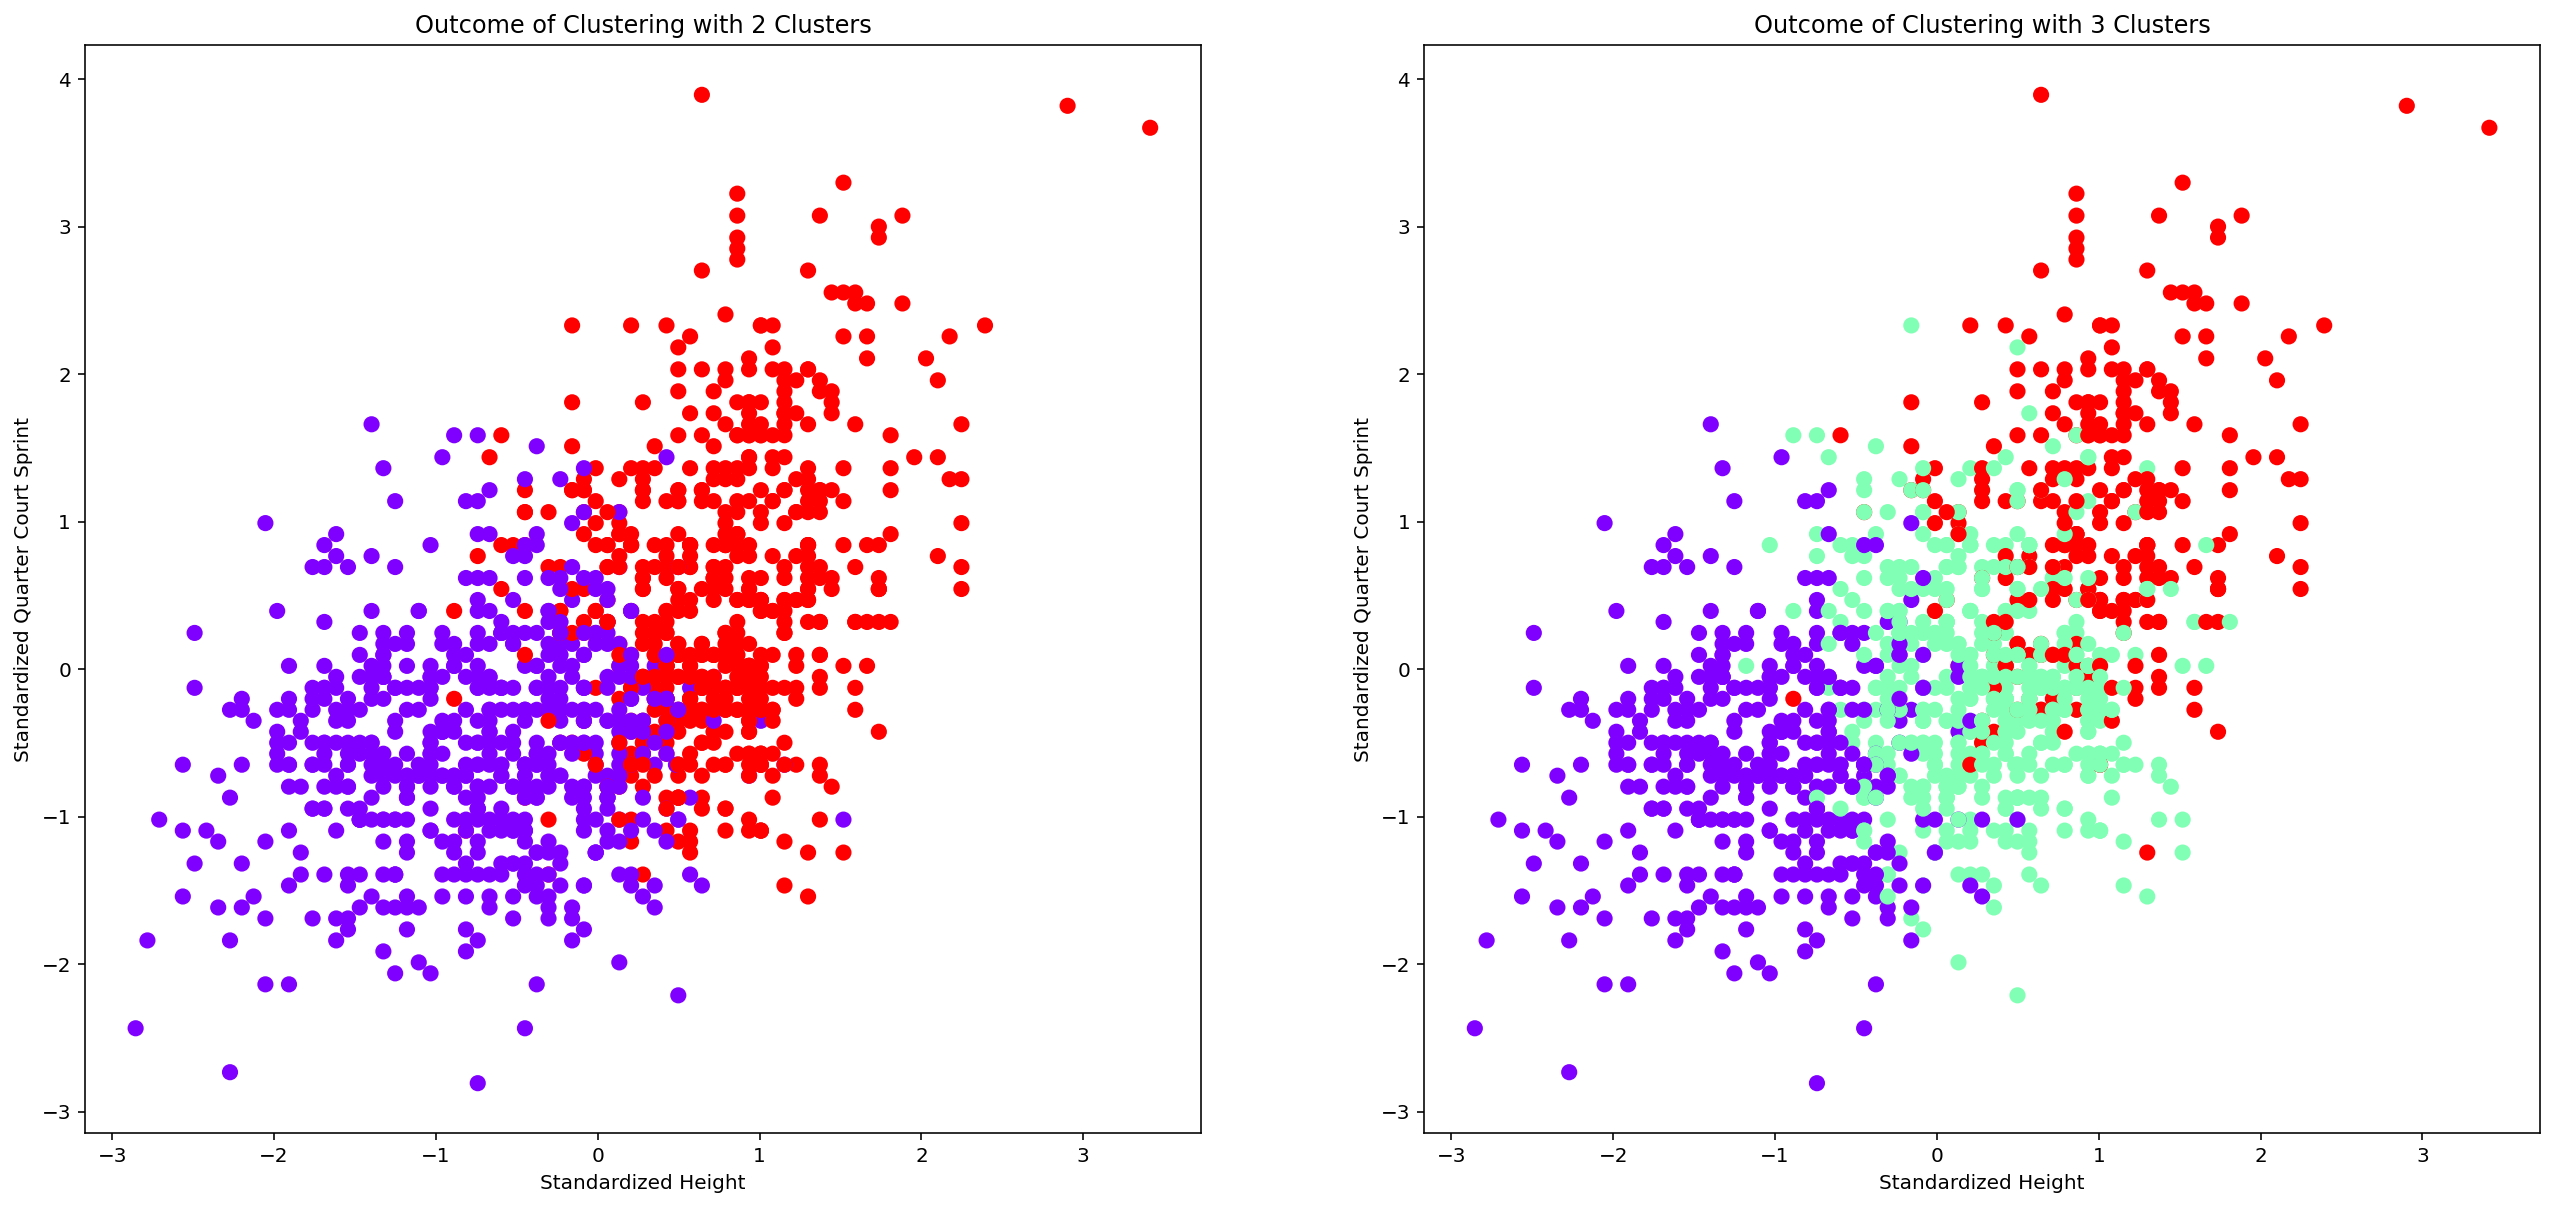

In [58]:
fig, ax = plt.subplots(ncols=2, figsize=(22,10))
ax[0].scatter(df_bio_std.iloc[:, 0], df_bio_std.iloc[:, 7], c=labels_2, s=50, cmap='rainbow')
ax[0].set_ylabel('Standardized Quarter Court Sprint'), ax[0].set_xlabel('Standardized Height'), ax[0].set_title('Outcome of Clustering with 2 Clusters')
ax[1].scatter(df_bio_std.iloc[:, 0], df_bio_std.iloc[:, 7], c=labels, s=50, cmap='rainbow')
ax[1].set_ylabel('Standardized Quarter Court Sprint'), ax[1].set_xlabel('Standardized Height'), ax[1].set_title('Outcome of Clustering with 3 Clusters')
plt.show()

From the above, it seems that two or three clusters would work to split up the players. Traditionally, basketball is played with 5 positions. However,there is reasoning to bucket these positions as Guards, Forwards, Centers or simply Guards, and Forwards. Let us exmaine the labels comparedto the slug positions listed in the data. 

In [59]:
label_analysis = pd.DataFrame([df['slugPosition'], labels_2, labels]).transpose().rename(columns={'Unnamed 0':'2_Clusters', 'Unnamed 1':'3_Clusters'})

In [60]:
pd.DataFrame([label_analysis[label_analysis['2_Clusters']==0]['slugPosition'].value_counts(normalize=True),
              label_analysis[label_analysis['2_Clusters']==1]['slugPosition'].value_counts(normalize=True)]).transpose()

,slugPosition,slugPosition
PG,0.325464,NaN
SG,0.227656,0.025641
SG-SF,0.101180,0.030769
SF,0.097808,0.119658
PG-SG,0.080944,0.005128
SG-PG,0.064081,NaN
SF-SG,0.057336,0.015385
PF,0.016863,0.326496
SF-PF,0.015177,0.068376
PF-SF,0.010118,0.071795


In [61]:
pd.DataFrame([label_analysis[label_analysis['3_Clusters']==0]['slugPosition'].value_counts(normalize=True),
              label_analysis[label_analysis['3_Clusters']==1]['slugPosition'].value_counts(normalize=True),
              label_analysis[label_analysis['3_Clusters']==2]['slugPosition'].value_counts(normalize=True)]).transpose()

,slugPosition,slugPosition,slugPosition
PG,0.468828,0.009940,NaN
SG,0.244389,0.099404,0.007299
PG-SG,0.102244,0.017893,0.003650
SG-PG,0.074813,0.015905,NaN
SG-SF,0.062344,0.101392,0.007299
SF-SG,0.024938,0.065606,NaN
SF,0.022444,0.210736,0.047445
PF,NaN,0.250497,0.273723
SF-PF,NaN,0.077535,0.036496
PF-SF,NaN,0.067594,0.051095


From the clustering excersise, it does seem that working with two clusters is more appropriate. We can split the players up into 'Guards' and 'Forwards' by simply analyzing their currently slug position and assigning accordingly. To achieve this, we create a function and map it to the slug position column.

In [62]:
def position_categories(x):
    guard = ['PG', 'SG']
    if x[:2] in guard:
        return 'G'
    else:
        return 'F'

In [63]:
df['position'] = df['slugPosition'].map(position_categories)
df['position'].value_counts(normalize=True)

F    0.567063
G    0.432937
Name: position, dtype: float64

Now that we have the players split into two categories, let us see if the trend towards 3-point shooting presents itself in the data. In our case, we would expect a higher proportion of guards after 2010 as this is the position historically linked to elite 3-point shooting. 

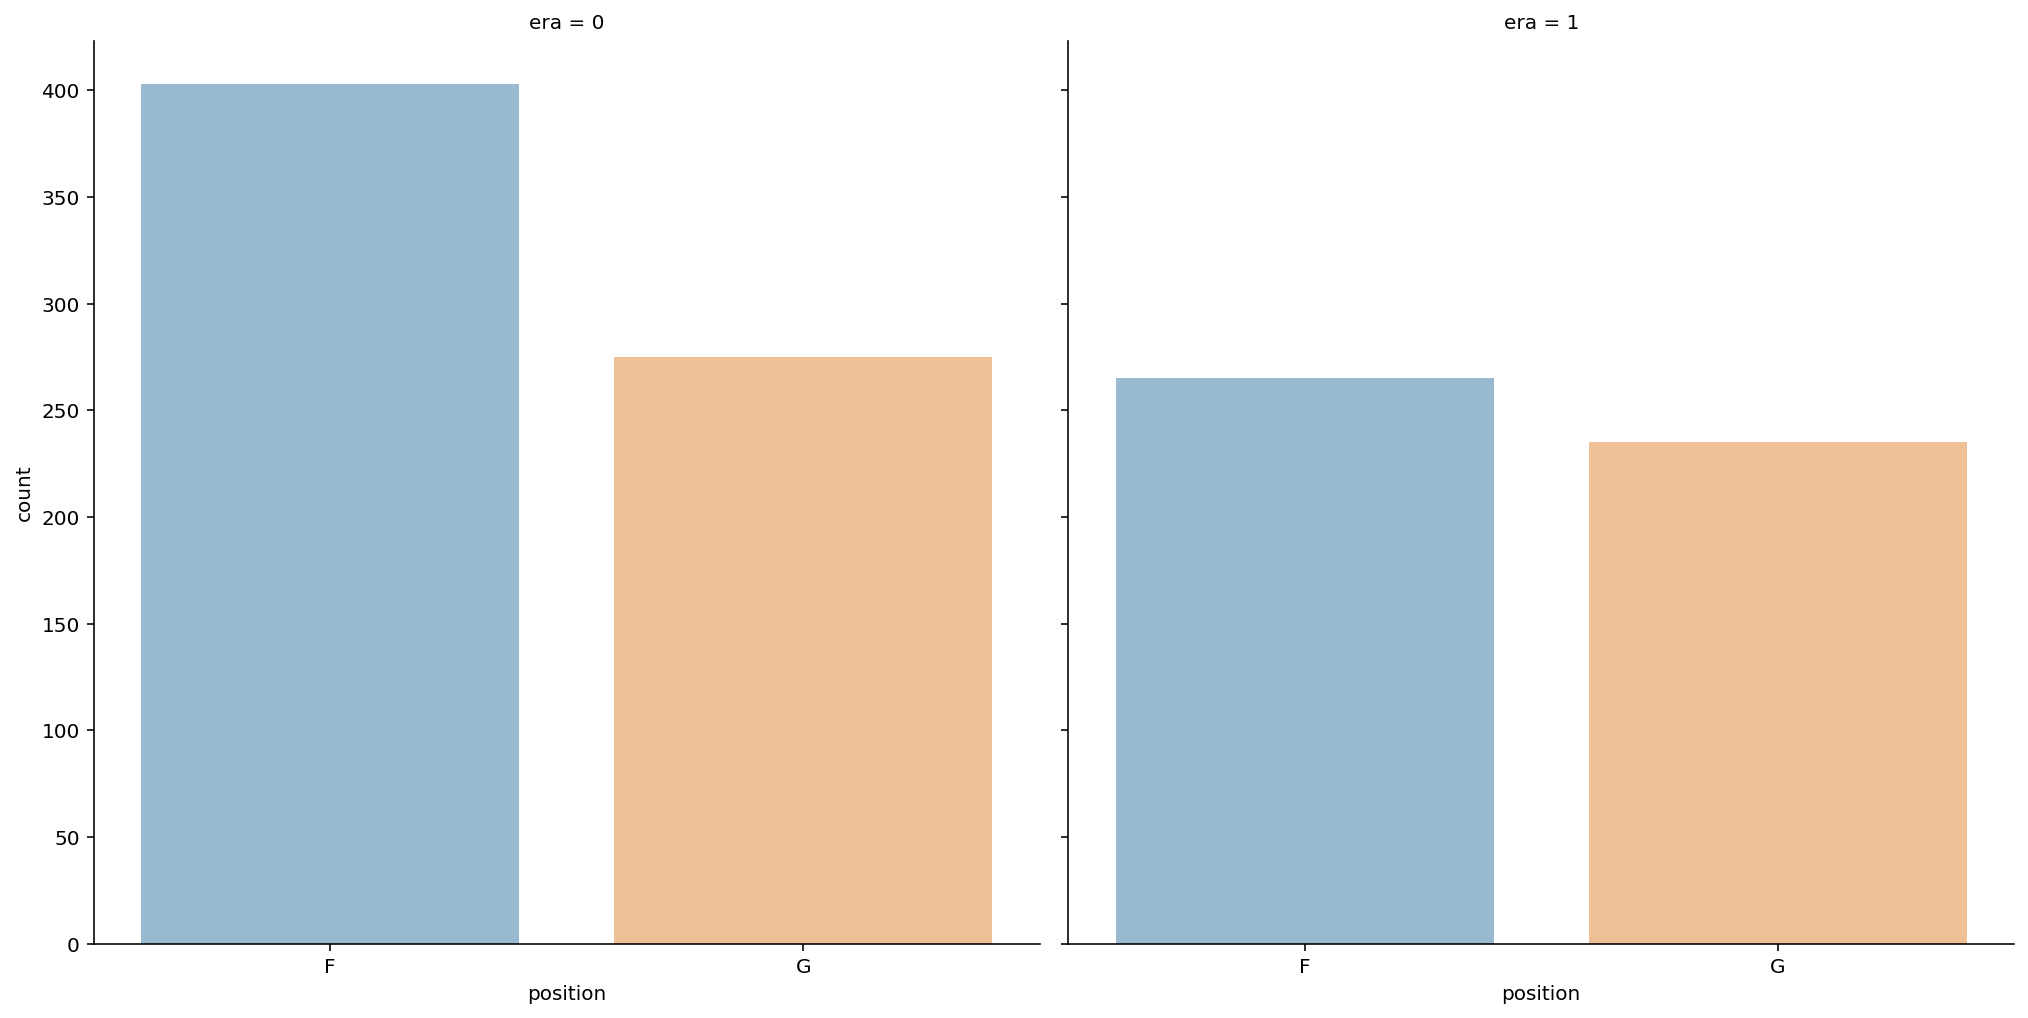

In [64]:
df['era'] = [1 if i > 2010 else 0 for i in df['yearCombine']]
sns.catplot(x='position', col='era', data=df, kind='count', height=7, aspect=1, alpha=0.5);
plt.show()

In [65]:
df[df['era']==0]['position'].value_counts(normalize=True)

F    0.594395
G    0.405605
Name: position, dtype: float64

In [66]:
df[df['era']==1]['position'].value_counts(normalize=True)

F    0.53
G    0.47
Name: position, dtype: float64

# 4. Modelling

This is a classification problem so I have selected Logistic Regression, Decision Tree (Bagging) and Gradient Boosting as my models.

### Logistic Regression

In [67]:
# Setting our predictor and target variables

X = df[['heightWOShoesInches', 'weightLBS', 'wingspanInches', 'reachStandingInches', 'verticalLeapStandingInches', 'verticalLeapMaxInches',
       'timeLaneAgility','timeThreeQuarterCourtSprint','position', 'era']]
target = df['Success']

In [68]:
X = pd.get_dummies(X, drop_first=True, columns=['position']) # creating a dummy variable from the position feature

In [69]:
# Splitting our data into a test and train. We set it so that is stratifies according to our target variable. This is done because there is a class
# inbalance in our target, so we want to ensure that the same proporation is of our target variable is represented in the train and test sets. 
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, stratify=target, random_state = 1)

In [70]:
# Let's test the shapes of the train test split to see if it is what we would expect. 

print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))
print('\n')
print('The positive class ratio in train set is: {:.3f}'.format(y_train.value_counts(normalize=True)[1]))
print('The positive class ratio in test set is: {:.3f}'.format(y_test.value_counts(normalize=True)[1]))

X_train shape: (942, 10)
X_test shape: (236, 10)
y_train shape: (942,)
y_test shape: (236,)


The positive class ratio in train set is: 0.354
The positive class ratio in test set is: 0.356


From the above, we can see that the train test split produced what we expected. Additionally, the stratification across our target variable worked as well. 

Now, let us run a simple Logistic Regression Model and analyze the outcome. First, let us standardize our data.

In [71]:
X_train_std = pd.DataFrame(scaler.fit_transform(X_train.iloc[:,0:8]), columns=['heightWOShoesInches', 'weightLBS', 'wingspanInches', 'reachStandingInches', 'verticalLeapStandingInches', 'verticalLeapMaxInches',
       'timeLaneAgility','timeThreeQuarterCourtSprint'])
X_train_std = pd.concat([X_train_std, X_train[['position_G', 'era']].reset_index(drop=True)], axis=1) 

X_test_std = pd.DataFrame(scaler.transform(X_test.iloc[:,0:8]), columns=['heightWOShoesInches', 'weightLBS', 'wingspanInches', 'reachStandingInches', 'verticalLeapStandingInches', 'verticalLeapMaxInches',
       'timeLaneAgility','timeThreeQuarterCourtSprint'])
X_test_std = pd.concat([X_test_std, X_test[['position_G', 'era']].reset_index(drop=True)], axis=1) 

In [72]:
model = LogisticRegression(max_iter=1000, random_state=1)
model.fit(X_train_std, y_train)
print('This is the training score: {:.3f}'.format(model.score(X_train_std, y_train)))
print('This is the testing score: {:.3f}'.format(model.score(X_test_std, y_test)))

This is the training score: 0.660
This is the testing score: 0.669


Now, let us see if we can achieve a better model using some regularization. 

Because my dataset is small, I do not want to keep using the train and test split for my models moving forward. Rather, we will use cross-validation make sure the folds are stratified. In order to achieve this, we will leverage the inbuilt Stratified K Fold function from Scikit-learn. 

In [73]:
X_std = pd.DataFrame(scaler.fit_transform(X.iloc[:,0:8]), columns = ['heightWOShoesInches', 'weightLBS', 'wingspanInches', 'reachStandingInches', 'verticalLeapStandingInches', 'verticalLeapMaxInches',
       'timeLaneAgility','timeThreeQuarterCourtSprint'])
X_std = pd.concat([X_std, X[['position_G', 'era']].reset_index(drop=True)], axis=1)

In [74]:
folds = StratifiedKFold(n_splits=5)

In [75]:
model_lr_reg = LogisticRegressionCV(Cs=np.logspace(-4, 4, 20),
                                solver='lbfgs', 
                                penalty='l2', cv=folds, max_iter=5000)
model_lr_reg.fit(X_std, target)
print('Average accuracy in our cross-validation: {:.3f}'.format(cross_val_score(model_lr_reg, X_std, target, cv=folds).mean()))

Average accuracy in our cross-validation: 0.652


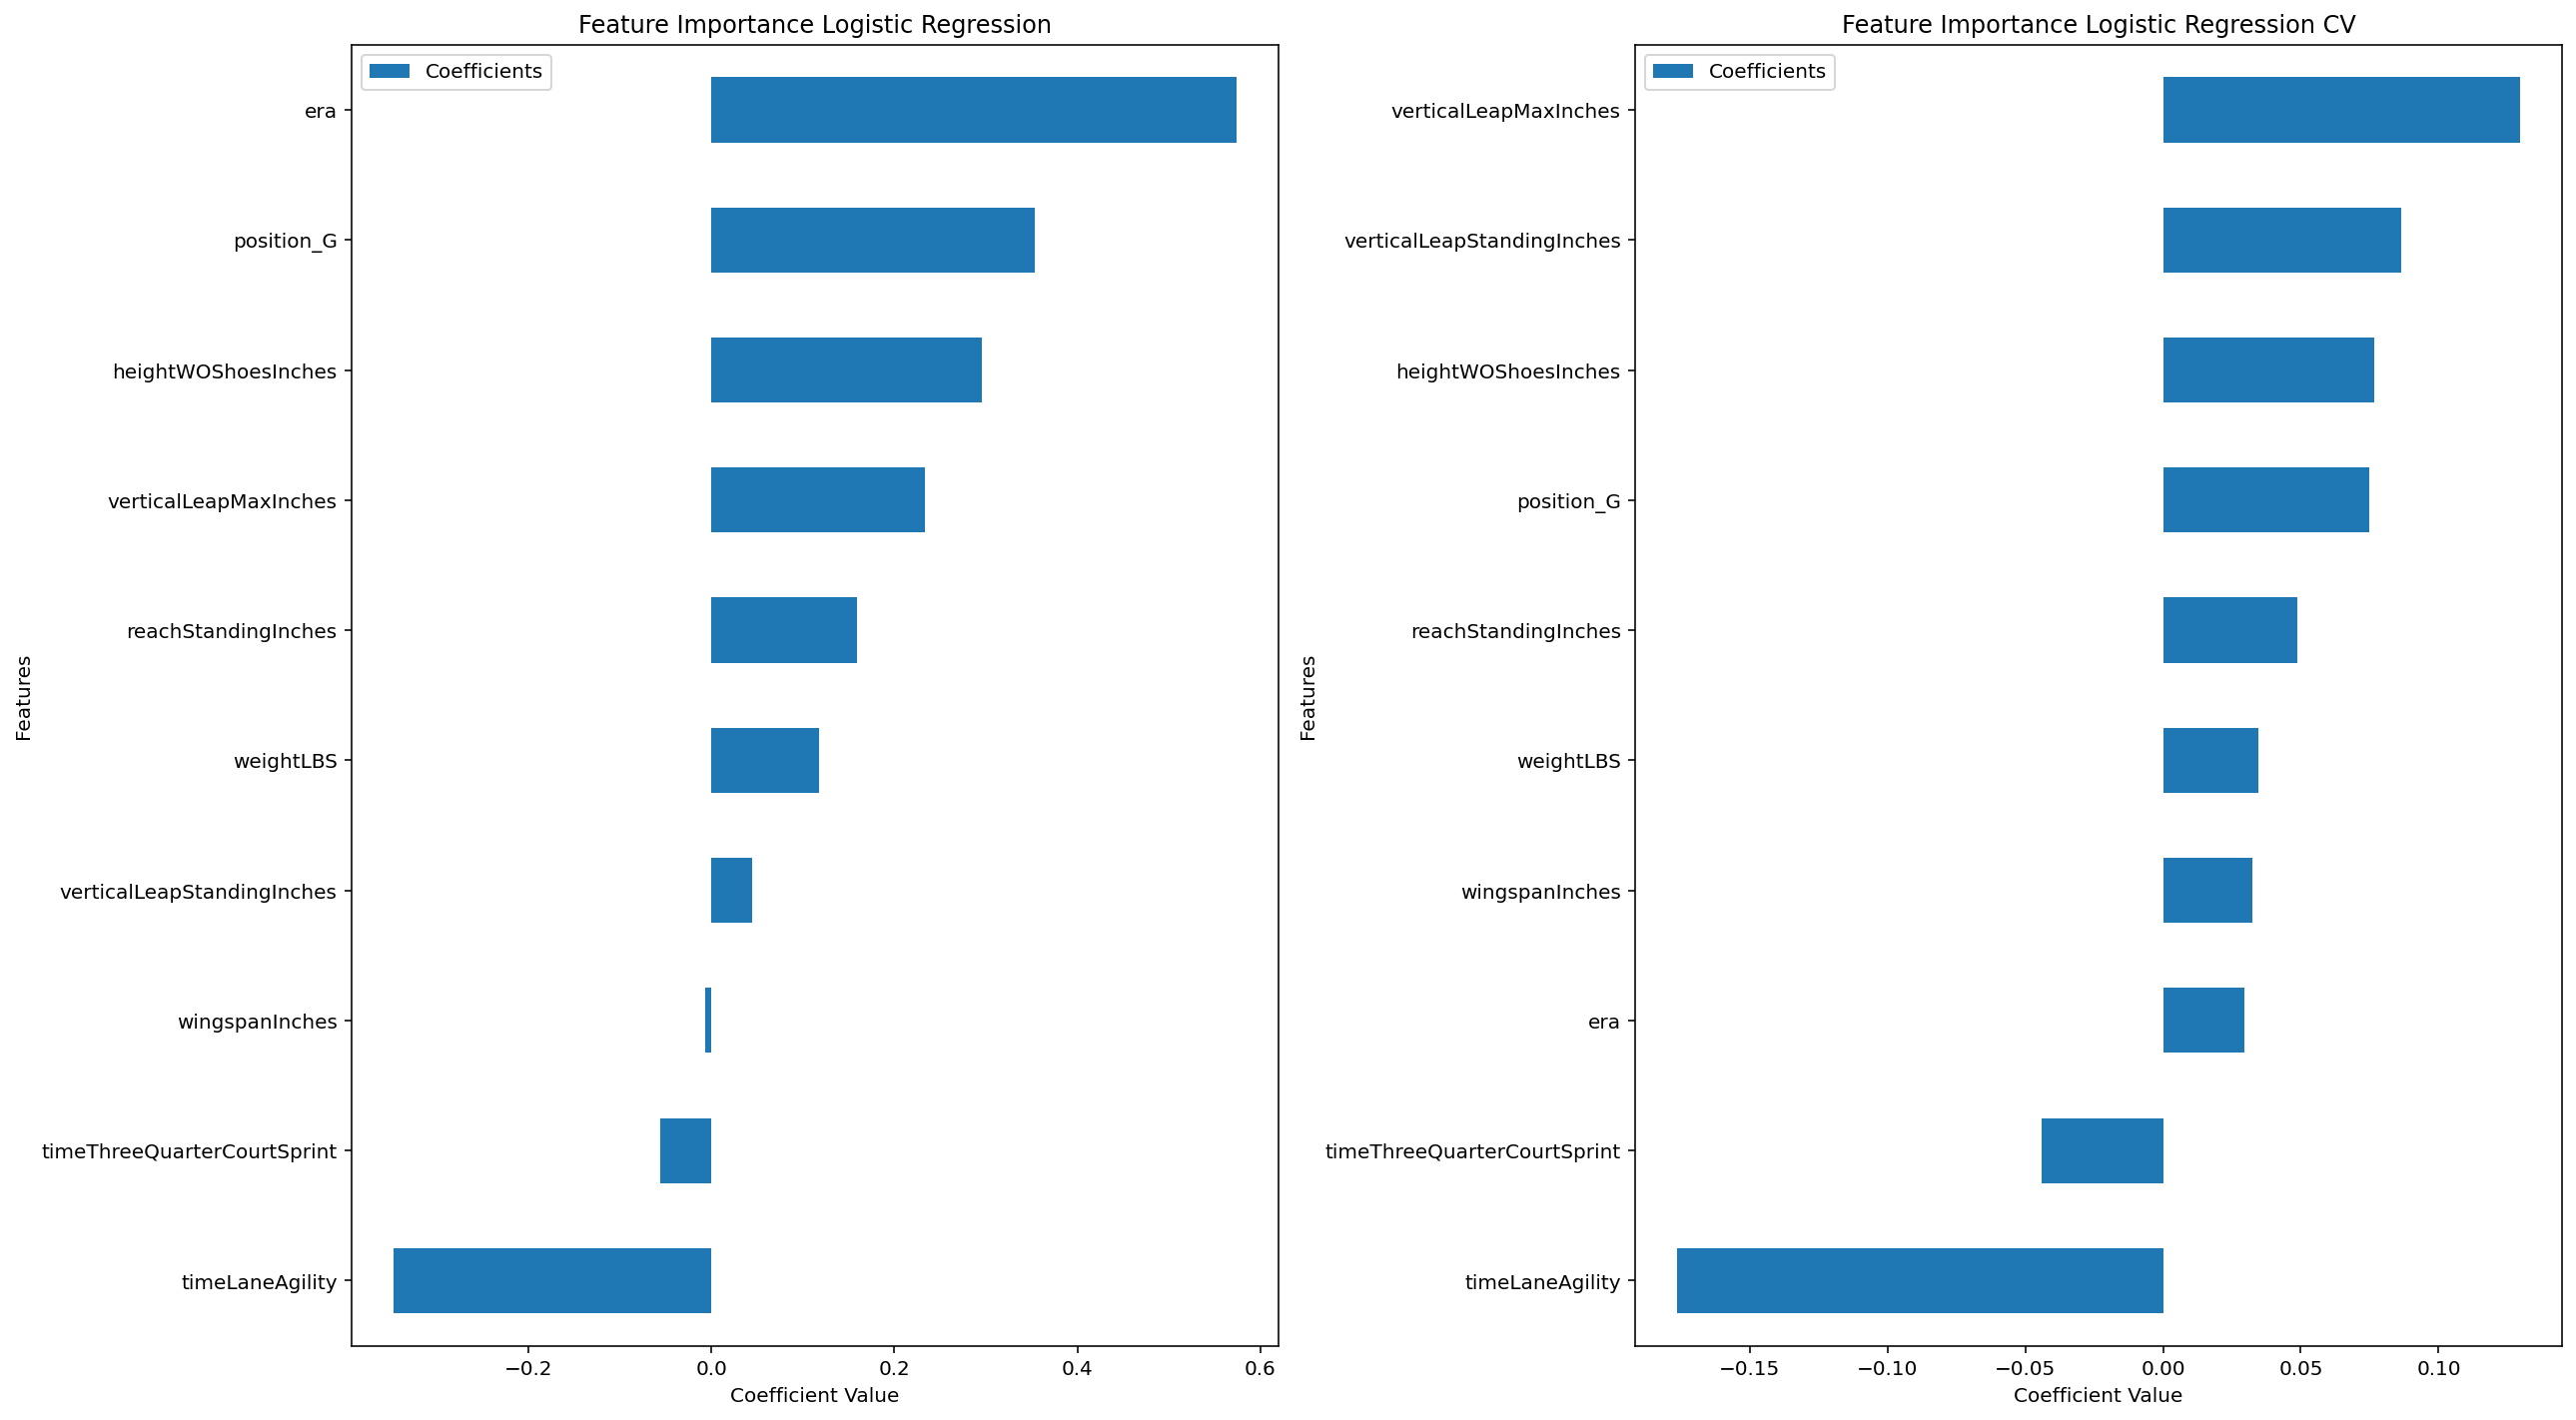

In [76]:
fig, ax = plt.subplots(ncols=2, figsize=(18,10))

pd.DataFrame(list(zip(X.columns, model.coef_[0])), columns=['Features', 'Coefficients']).sort_values(by='Coefficients')\
    .plot(kind='barh', x='Features', y='Coefficients', ax=ax[0])
pd.DataFrame(list(zip(X.columns, model_lr_reg.coef_[0])), columns=['Features', 'Coefficients']).sort_values(by='Coefficients')\
    .plot(kind='barh', x='Features', y='Coefficients', ax=ax[1])

ax[0].set_title('Feature Importance Logistic Regression'), ax[1].set_title('Feature Importance Logistic Regression CV')
ax[0].set_ylabel('Features'), ax[1].set_ylabel('Features'), 
ax[0].set_xlabel('Coefficient Value'), ax[1].set_xlabel('Coefficient Value')


plt.tight_layout()

From the feature importance diagram, we see the general trend that we would expect. The taller, faster and more agile you are, the more likely you will be a success in the NBA. The most important biometric statistics, however, are your agility and your vertical leap. It is suprising that agility is such a dominant feature with respect to the other athletic features. From a basketball context, this can be somewhat explained as higher agility means you are more able to change directions. This is a disreable trait on both the offensive and deffensive end. 

Finally, if you were drafted after 2010 you are more likely to have had a successful NBA career. And, guards are much more likely to have a successful NBA career than forwards are. 

### Decision Trees

In [77]:
base_estimator = DecisionTreeClassifier(max_depth=3)
model_dt = BaggingClassifier(base_estimator=base_estimator,
                           n_estimators=100,
                           random_state=1)

model_dt.fit(X_std, target)

cross_val_score(model_dt, X_std, target).mean()

0.6493941579516769

In [78]:
# Now, let us try and improve on the bagging decision tree using grid search to tune the hyperparameters. 
model_dt = BaggingClassifier(base_estimator=base_estimator, random_state=1)
params = {'max_samples': np.linspace(0.8, 1.0, 3),
          'max_features': range(int(3/4.*X_std.shape[1]), X_std.shape[1]+1),
         'n_estimators': range(50,100,20)}

grid_dt = GridSearchCV(model_dt, param_grid=params, cv=folds, n_jobs=-2)
grid_dt.fit(X_std, target)
best_dt = grid_dt.best_estimator_
best_dt

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                  max_features=10, n_estimators=90, random_state=1)

### Gradient Boosting

In [79]:
model_gb = GradientBoostingClassifier(random_state=1)

In [80]:
params_gb = {'learning_rate': np.linspace(0.1,1,6),
             'n_estimators': range(50,150,10),
             'max_depth': range(2,5,1)}
grid_gb = GridSearchCV(model_gb, param_grid=params_gb, cv=folds, n_jobs=-2)
grid_gb.fit(X_std, target)
grid_gb.best_estimator_

GradientBoostingClassifier(max_depth=2, n_estimators=50, random_state=1)

### Model Evaluation

All models will be evaluated using standard classification evaluation techniques. The higest performing model will be analyzed further than the others. 

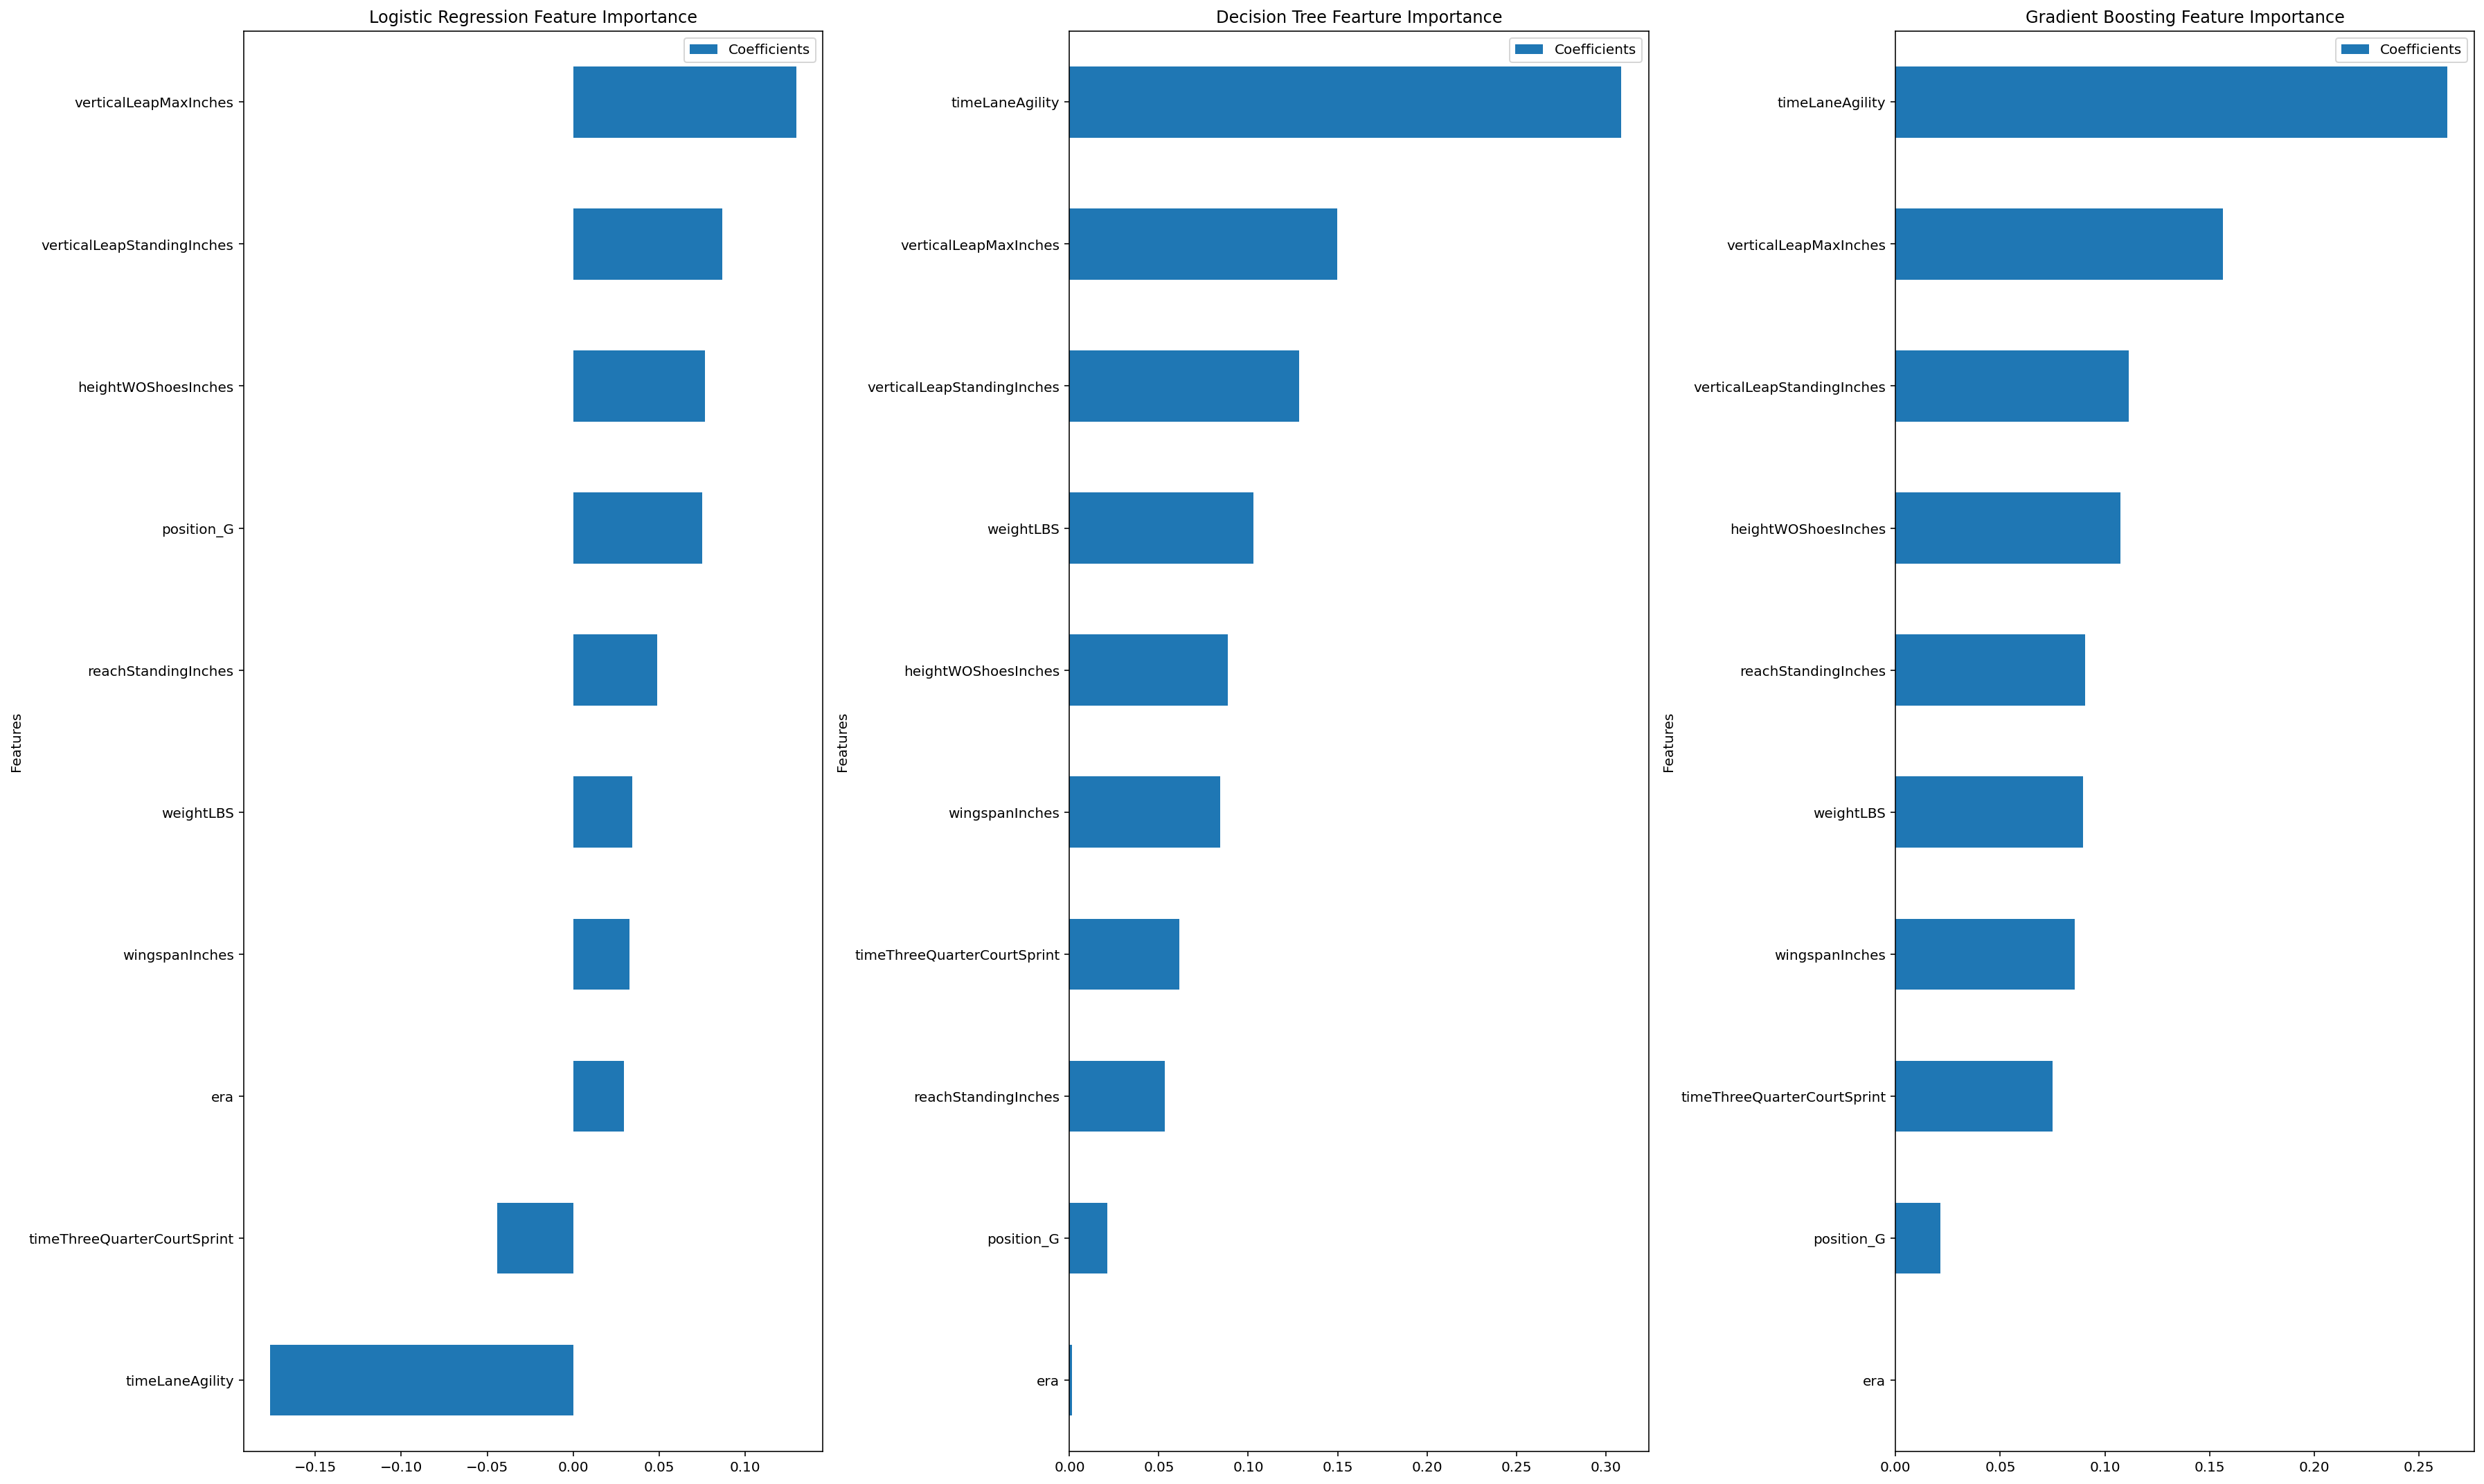

In [81]:
fig, ax = plt.subplots(ncols=3, figsize=(25,15))

pd.DataFrame(list(zip(X.columns, model_lr_reg.coef_[0])), columns=['Features', 'Coefficients']).sort_values(by='Coefficients')\
    .plot(kind='barh', x='Features', y='Coefficients', ax=ax[0])
pd.DataFrame(list(zip(X.columns, np.mean([tree.feature_importances_ for tree in best_dt.estimators_], axis=0))), columns=['Features', 'Coefficients']).sort_values(by='Coefficients')\
    .plot(kind='barh', x='Features', y='Coefficients', ax=ax[1])
pd.DataFrame(list(zip(X.columns, grid_gb.best_estimator_.feature_importances_)), columns=['Features', 'Coefficients']).sort_values(by='Coefficients')\
    .plot(kind='barh', x='Features', y='Coefficients', ax=ax[2])

ax[0].set_title('Logistic Regression Feature Importance'), ax[1].set_title('Decision Tree Fearture Importance'), ax[2].set_title('Gradient Boosting Feature Importance')
plt.tight_layout()
plt.show()

From the above feature importance graphs, we see some common themes across all of the models. The engineering features of era, and position do not hold much value. This implies that the transition of the NBA to a 3-point dominant league is not strongly reflected in the biometric data of the successful players. Furthermore, the top features are consistent across the models. There is a clear focus on the agility and explosiveness of a player. Suprisingly, height is not one of the top three features in any of the models. 

Let us move forward with the evaluation of the models by looking at their classification reports, confusion matrices and ROC/PR curves.

In [82]:
# Asking each model to predict on the full data set. These predictions will be used to calculate the evaluation metrics. 
predictions_lr = model_lr_reg.predict(X_std)
predictions_dt = grid_dt.predict(X_std)
predictions_gb = grid_gb.predict(X_std)

In [83]:
# Printing our our classification reports for each of the models. 
print('Logistic Regression:','\n',classification_report(target, predictions_lr), '\n')

print('Decision Tree:','\n',classification_report(target, predictions_dt),'\n')

print('Gradient Boosting:','\n',classification_report(target, predictions_gb))

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.65      0.99      0.79       761
           1       0.75      0.03      0.06       417

    accuracy                           0.65      1178
   macro avg       0.70      0.51      0.42      1178
weighted avg       0.69      0.65      0.53      1178
 

Decision Tree: 
               precision    recall  f1-score   support

           0       0.68      0.96      0.79       761
           1       0.66      0.16      0.26       417

    accuracy                           0.67      1178
   macro avg       0.67      0.56      0.52      1178
weighted avg       0.67      0.67      0.60      1178
 

Gradient Boosting: 
               precision    recall  f1-score   support

           0       0.69      0.96      0.80       761
           1       0.75      0.22      0.34       417

    accuracy                           0.70      1178
   macro avg       0.72      0.59      0.57      1178
weighted 

Analyzing the classification reports, we begin to see what our models are good at. Firstly, all three models have a strong recall regarding the negative outcome (not being a success). This means they were all able to correctly identify all the true not success instances. However, if our models simply guessed the majority class, they would have a perfect recall for the negative outcome. Therefore, this recall value isn't that impressive. 

Focusing on our positive class, we are seeing strong precision but very poor recall across the board. This implies that our model is very hesitant to predict a positive class, but when it does, it predicts it well. As we move down our models, we see an increase in the recall of the positive class, at the expense of a decrease in the precision. Our model is becoming more confident and predicting more successes and is therefore predicting a few more incorrectly. 

Based on accuracy, the gradient boosting model is the highest performing one. 

In [84]:
# creating a function that generates a confusion matrix dataframe that we can pass to a seaborn heatmap. 
def confusion_matrix_df(predictions,target):
    cm = confusion_matrix(target, predictions)
    df = pd.DataFrame(cm, columns=np.unique(target))
    df.index.name = 'Actual'
    df.columns.name = 'Prediction'
    return df

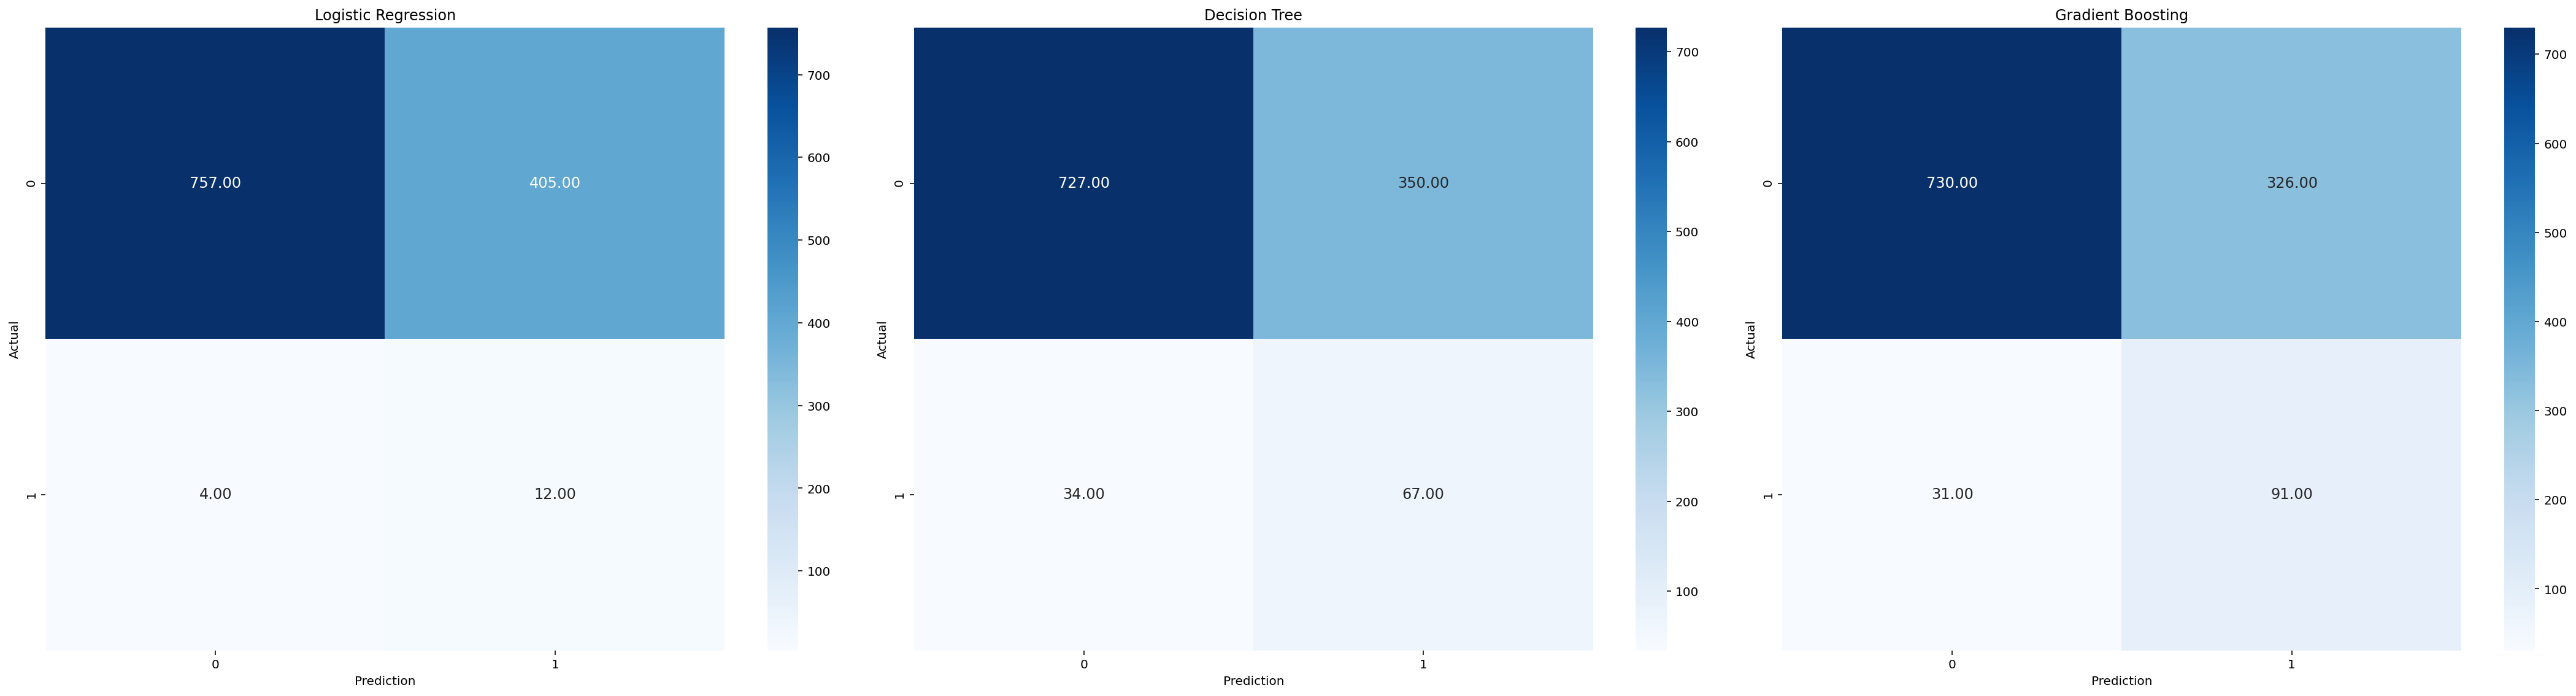

In [85]:
# plotting all the confusion matrices as heatmaps
fig, ax = plt.subplots(ncols=3, figsize=(30,8))
sns.heatmap(confusion_matrix_df(target, predictions_lr),cmap="Blues", annot=True, annot_kws={"size": 12}, fmt = '.2f', ax=ax[0])
sns.heatmap(confusion_matrix_df(target, predictions_dt),cmap="Blues", annot=True, annot_kws={"size": 12}, fmt = '.2f', ax=ax[1])
sns.heatmap(confusion_matrix_df(target, predictions_gb),cmap="Blues", annot=True, annot_kws={"size": 12}, fmt = '.2f', ax=ax[2])
ax[0].set_title('Logistic Regression'), ax[1].set_title('Decision Tree'), ax[2].set_title('Gradient Boosting')
plt.tight_layout()
plt.show()

The confusion matrices tell the same story as the classification reports do. We are increasing our sensitivity at the expense of our specificity.

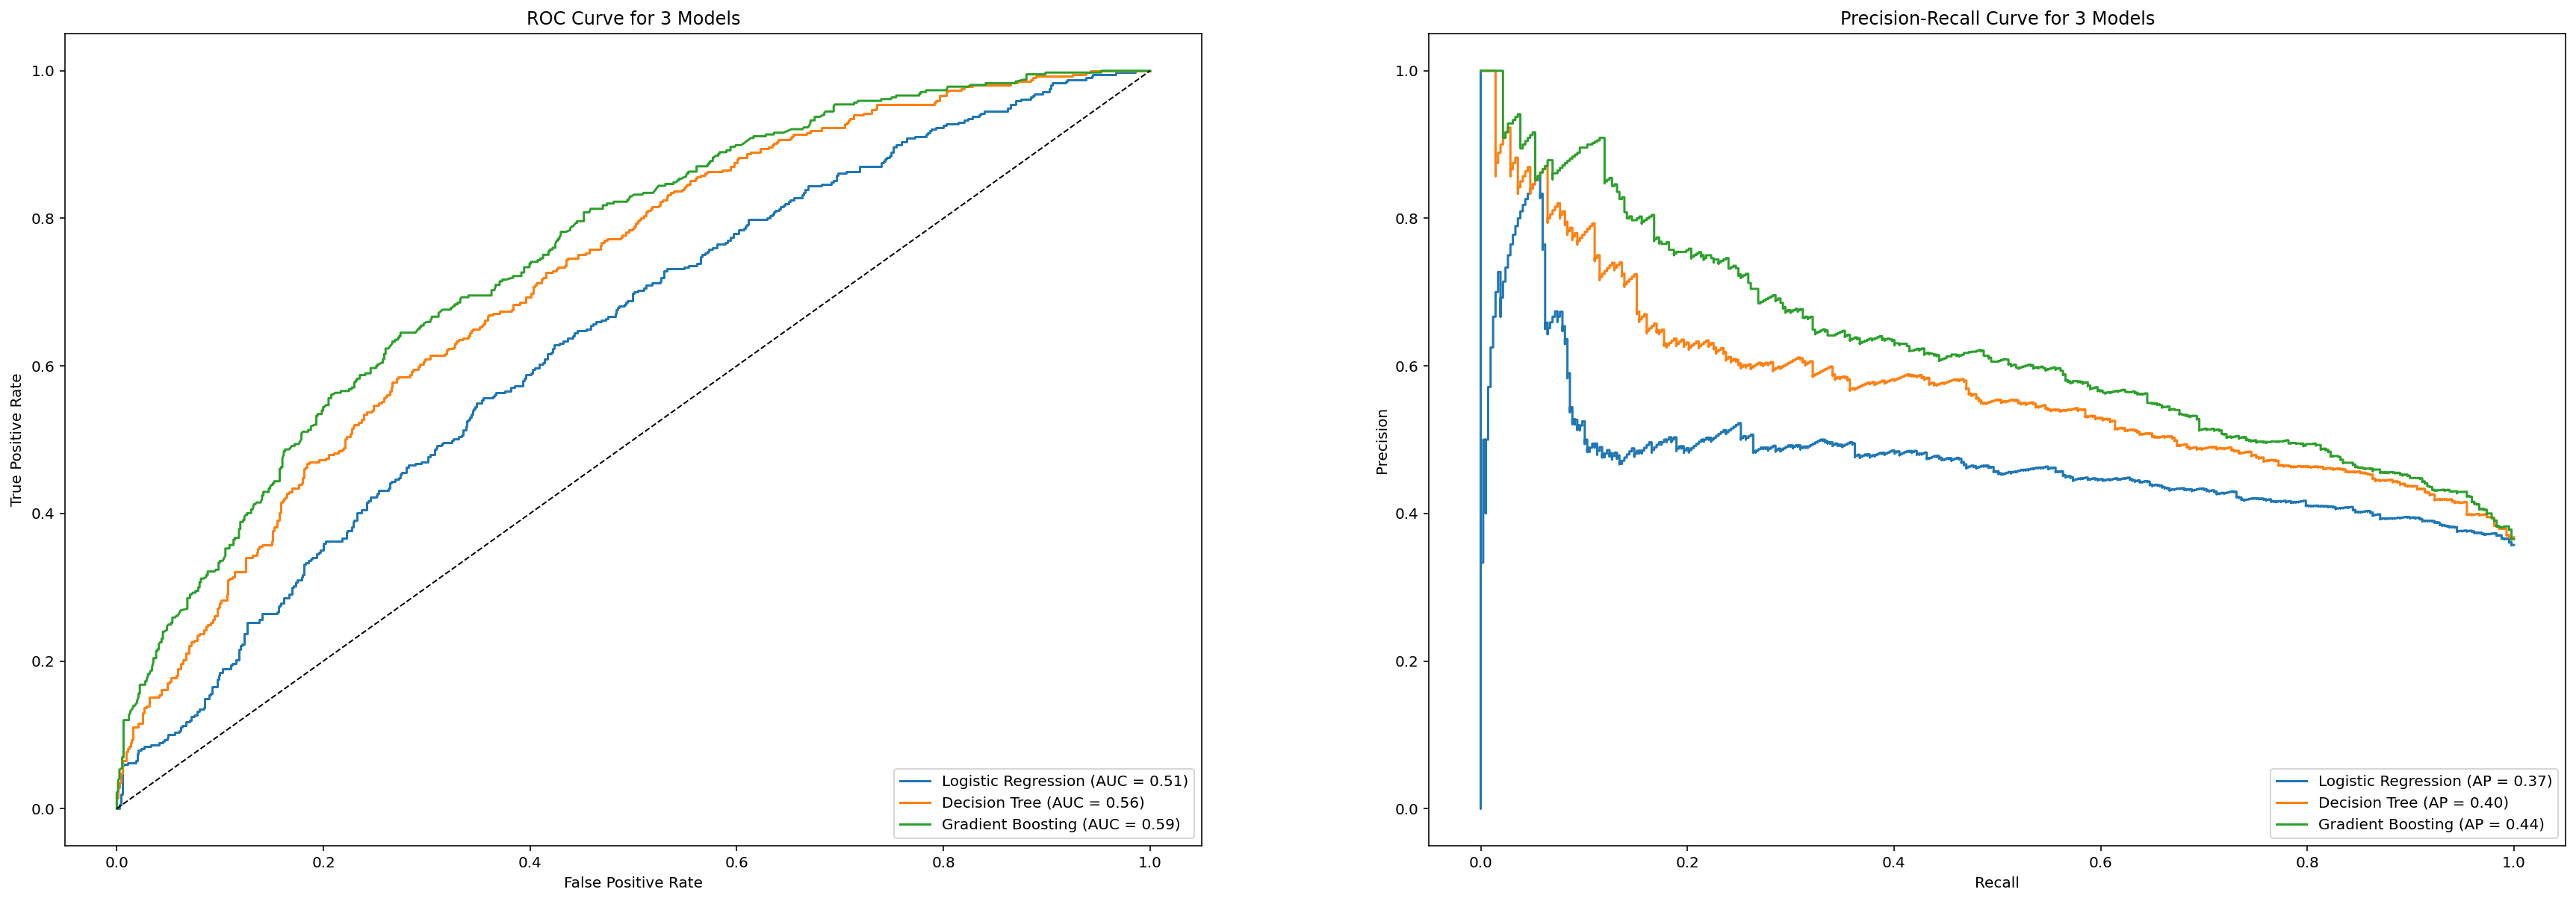

In [86]:
# Plotting the ROC and Precision-Recall curves for all the models 

fix, ax = plt.subplots(ncols=2, figsize=(30,10))
plot_roc_curve(model_lr_reg, X_std, target, ax=ax[0], label = 'Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(target, predictions_lr)))
plot_roc_curve(grid_dt, X_std, target, ax=ax[0], label='Decision Tree (AUC = {:.2f})'.format(roc_auc_score(target, predictions_dt)))
plot_roc_curve(grid_gb, X_std, target, ax=ax[0], label='Gradient Boosting (AUC = {:.2f})'.format(roc_auc_score(target, predictions_gb)))
ax[0].plot([0, 1], [0, 1], 'k--', linewidth=1)

plot_precision_recall_curve(model_lr_reg, X_std, target, ax=ax[1], label='Logistic Regression (AP = {:.2f})'.format(average_precision_score(target, predictions_lr)))
plot_precision_recall_curve(grid_dt, X_std, target, ax=ax[1], label='Decision Tree (AP = {:.2f})'.format(average_precision_score(target, predictions_dt)))
plot_precision_recall_curve(grid_gb, X_std, target, ax=ax[1], label='Gradient Boosting (AP = {:.2f})'.format(average_precision_score(target, predictions_gb)))
ax[1].legend(loc='lower right')

ax[0].set_title('ROC Curve for 3 Models'), ax[1].set_title('Precision-Recall Curve for 3 Models')
plt.show()

Our ROC graph shows three models that are better than a model with no predictive power, but not much better. The Gradient boosting model has the highest AUC but it is still an unimpressive number. 

The PR curve shows the relationship discussed above regarding precision and recall. If we wish to increase the recall for a model, we need to decrease the fall negatives by guessing more positive values. In turn, this most likely lowers our precision as more positive value guesses will lead to greater number of false positives. The Logistic Regression model is seemingly more sensitive to this transition than the other models. For a small increase in recall we are seeing immediate and large drops in precision.

# 5. Conclusion

Biometric data collected at the NBA Draft Combine has limited predictive power regarding the success of a prospect in the NBA. The most important features are a players agility and vertical leap followed by their height and weight (albeit at a much lower importance). Finally, being a guard does give you a slight edge. However, if the model predicts a 1, there is a high likelihood that the player will be a success. 

From these results, it can be postulated that a focus on the biometric data collected during the combine is effort better spent elsewhere. 


# 6. Areas for Future Work

Some areas for future work include, but are not limited to:
- Expanding the model to include player data from college to see if this increases predictive power.
- Re-running the model with different definitions of success
